<a href="https://colab.research.google.com/github/christopher-reed/CA-High-Value-Crops/blob/master/Crop_Weather_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formatting Weather Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_weather = pd.read_csv('county_level_weather.csv')
df_weather.head()

Unnamed: 0  County  Var  ...     October    November    December
0           0  Sierra  ppt  ...   33.582626   41.988926  120.442238
1           1  Sierra  ppt  ...  174.779312  504.357941  377.453613
2           2  Sierra  ppt  ...  202.075043  250.340317  253.627685
3           3  Sierra  ppt  ...   91.135620  504.704224  429.239380
4           4  Sierra  ppt  ...  103.931931  325.303803   62.782768

[5 rows x 16 columns]

In [3]:
df_weather['Var'].unique()

array(['ppt', 'tmax', 'tmin', 'tmean', 'vpdmax', 'vpdmin'], dtype=object)

**Currently the data is quite hard to query because you have to query the Var column and then select each month. It would be a little easier if we had a column for ppt in January or VPDmax in March.**

In [0]:
#Plan: Make a bunch of series and then concat them all into a df

#List the months and variables
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
variables = df_weather['Var'].unique()

#List to store all the dfs
df_list = []

#Iterate through months
for month in months:
  
  #Filter to month
  df_month = df_weather[['County', 'Year','Var', month]]
  
  #Iterate through vars
  for var in variables:
    
    #Name column
    desired_name = month+ '_' + var
   
    #Filter to variables
    df_month_var = df_month.loc[df_month['Var'] == var].rename(columns = {month:month+ '_' + var}).drop(['Var'], axis = 1)
    
    #Append to list
    df_list.append(df_month_var)


**We have a list of all of our dfs. We now want to merge them on county and year. We can use [reduce()](https://book.pythontips.com/en/latest/map_filter.html) from functools to do a "rolling" computation.**

In [0]:
from functools import reduce
df_weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'Year'],
                                            how='outer'), df_list)

**Check out the result. This will be much easier to query!**

In [6]:
df_weather_merged.head()

County  Year  January_ppt  ...  December_tmean  December_vpdmax  December_vpdmin
0  Sierra  1980   415.709686  ...        3.386014         7.433448         1.787973
1  Sierra  1981   236.459885  ...        2.496554         4.770134         0.884527
2  Sierra  1982   229.290253  ...       -0.805878         4.395406         0.615068
3  Sierra  1983   232.798508  ...        0.471892         3.131824         0.621014
4  Sierra  1984    17.905682  ...       -1.388446         4.449865         0.787703

[5 rows x 74 columns]

# Yield Data

**Crop Selection**

**Load in yield data. Inspect it.**

In [7]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

Year  Commodity Code    Crop Name  ...  Price per Unit   Unit  Total Value
0  1980          261999  ALMONDS ALL  ...          3000.0  TONS    39651000.0
1  1980          261999  ALMONDS ALL  ...          3600.0  TONS       43200.0
2  1980          261999  ALMONDS ALL  ...          2800.0  TONS     5880000.0
3  1980          261999  ALMONDS ALL  ...          1440.0  TONS      818000.0
4  1980          261999  ALMONDS ALL  ...          3000.0  TONS    42600000.0

[5 rows x 11 columns]

In [8]:
df_counties['Crop Name'].unique()

array(['ALMONDS ALL', 'GRAPES WINE', 'WALNUTS ENGLISH',
       'TOMATOES PROCESSING', 'PISTACHIOS', 'GRAPES TABLE',
       'LETTUCE HEAD', 'BERRIES STRAWBERRIES PROCESSING'], dtype=object)

# Join Yield and Weather

**Next step is to introduce the yield data which was obtained in a seperate notebook. We want to join this to the weather data on county and year.**

In [9]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

Year  Commodity Code    Crop Name  ...  Price per Unit   Unit  Total Value
0  1980          261999  ALMONDS ALL  ...          3000.0  TONS    39651000.0
1  1980          261999  ALMONDS ALL  ...          3600.0  TONS       43200.0
2  1980          261999  ALMONDS ALL  ...          2800.0  TONS     5880000.0
3  1980          261999  ALMONDS ALL  ...          1440.0  TONS      818000.0
4  1980          261999  ALMONDS ALL  ...          3000.0  TONS    42600000.0

[5 rows x 11 columns]

**Perform join.**

In [10]:


#Join on county and year fields. Use inner join b/c we want data that has BOTH
#yield and weather data
df_weather_yield = df_weather_merged.merge(df_counties, how = 'inner', on = ['County', 'Year'])

#Inspect
df_weather_yield.head()

County  Year  January_ppt  ...  Price per Unit   Unit  Total Value
0  Sacramento  1980   144.467880  ...           210.0  TONS     5628000.0
1  Sacramento  1980   144.467880  ...           951.0  TONS      351000.0
2  Sacramento  1980   144.467880  ...            48.0  TONS    11805000.0
3  Sacramento  1981   132.503296  ...           224.0  TONS     5242000.0
4  Sacramento  1981   132.503296  ...          1000.0  TONS      410000.0

[5 rows x 83 columns]

# Feature Engineering

**It is possible that cumulative precipitation is more useful than the precipitation in one month. Sum up three months of precipitation data.**

**Jan + Feb + Mar = JPM**
**Feb + Mar + Apr = FMA Precip**

**So on and so forth...**

In [0]:
#Function to add a "window" of precipitation
def precip_window(month_window):

  #Create name
  var = month_window[0][0] + month_window[1][0] + month_window[2][0]
  var_ppt = var + '_ppt'

  #Make new column
  df_weather_yield[var_ppt] = df_weather_yield[month_window[0]] + df_weather_yield[month_window[1]] + df_weather_yield[month_window[2]]


In [0]:
#List of all possible windows
windows = [['January_ppt', 'February_ppt', 'March_ppt'],
           ['February_ppt', 'March_ppt', 'April_ppt'],
           ['March_ppt', 'April_ppt', 'May_ppt'],
           ['April_ppt', 'May_ppt', 'June_ppt'],
           ['May_ppt', 'June_ppt', 'July_ppt'],
           ['June_ppt', 'July_ppt', 'August_ppt'],
           ['July_ppt', 'August_ppt', 'September_ppt'],
           ['August_ppt', 'September_ppt', 'October_ppt'],
           ['September_ppt', 'October_ppt', 'November_ppt'],
           ['October_ppt', 'November_ppt', 'December_ppt'],
           ['November_ppt', 'December_ppt', 'January_ppt'],
            ['December_ppt', 'January_ppt', 'February_ppt']]

#Use function
for window in windows:
  precip_window(window)

**In our model it will be important to consider the squares of some of our variables. We can add those columns now.**

In [0]:
#We don't want to square these!
unaltered_vars = ['Year','County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for column in list(df_weather_yield.columns):
  
  if column in unaltered_vars:
    continue
    
  else:
    name = column
    new_name = column + '_2'
    
    df_weather_yield[new_name] = df_weather_yield.apply(lambda x: x[name]**2, axis = 1)

**Inspect output. Should be over 170 columns. The variables we didn't square are still there, they are just not displayed in this output.**

In [14]:
df_weather_yield.head()

County  Year  January_ppt  ...     OND_ppt_2      NDJ_ppt_2      DJF_ppt_2
0  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
1  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
2  Sacramento  1980   144.467880  ...   3367.605970   39882.113163  136176.602542
3  Sacramento  1981   132.503296  ...  94141.969692  146961.842448   63320.316365
4  Sacramento  1981   132.503296  ...  94141.969692  146961.842448   63320.316365

[5 rows x 179 columns]

**In this study we are going to account for fixed effects within each county. We can do this by creating dummy variables for each county. Use [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to do this.**

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(df_weather_yield['County'])

#Concat them to original df and rename to preserve original
df_fixed = pd.concat([df_weather_yield, dummy_counties], axis = 1)
df_fixed.shape

(4852, 228)

**At this point we are going to do seperate operations for the df that considers fixed effects (df_fixed) and the df that does not consider fixed effect (df_weather_yield). Doing this because it will make the exploratory analysis much cleaner.**

**Fixed Effects: Now we are going to center all of our variables on their respective mean over the domain. Achieved by subtracting each column by its mean. We will groupby the crop name.**

In [0]:
#Groupby
df_means_fixed = df_fixed.groupby('Crop Name').mean()
df_means_fixed = df_means_fixed.reset_index()

#Inspect
df_means_fixed.head()

Crop Name         Year  ...      Yolo      Yuba
0                      ALMONDS ALL  1997.301611  ...  0.055637  0.055637
1  BERRIES STRAWBERRIES PROCESSING  2000.093525  ...  0.000000  0.000000
2                     GRAPES TABLE  1997.850000  ...  0.006667  0.003333
3                      GRAPES WINE  1999.517872  ...  0.031588  0.011638
4                     LETTUCE HEAD  1999.721622  ...  0.000000  0.000000

[5 rows x 226 columns]

**Fixed Effects: Next step is to center our data on the respective mean.**

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered_fixed = df_fixed.copy(deep = True)

#Specify variables
variables = list(df_fixed.columns)
crops = df_fixed['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']


for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means_fixed.loc[df_means_fixed['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_fixed[df_fixed['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered_fixed.loc[df_centered_fixed['Crop Name'] == crop, var] = result

**Fixed Effects: Inspect the data**

In [0]:
df_centered_fixed.head()

County       Year  January_ppt  ...   Ventura      Yolo      Yuba
0  Sacramento -19.517872    20.740280  ...  0.000000 -0.031588 -0.011638
1  Sacramento -17.262755    17.726157  ... -0.007653 -0.032313 -0.032313
2  Sacramento -16.895935    56.351026  ... -0.014634 -0.061789  0.000000
3  Sacramento -18.517872     8.775696  ...  0.000000 -0.031588 -0.011638
4  Sacramento -16.262755     5.761573  ... -0.007653 -0.032313 -0.032313

[5 rows x 228 columns]

**Now perform the above operations, but now for the df not considering fixed effects (df_weather_yield).**

In [0]:
#Groupby
df_means = df_weather_yield.groupby('Crop Name').mean()
df_means = df_means.reset_index()

#Inspect
df_means_fixed.head()

Crop Name         Year  ...      Yolo      Yuba
0                      ALMONDS ALL  1997.301611  ...  0.055637  0.055637
1  BERRIES STRAWBERRIES PROCESSING  2000.093525  ...  0.000000  0.000000
2                     GRAPES TABLE  1997.850000  ...  0.006667  0.003333
3                      GRAPES WINE  1999.517872  ...  0.031588  0.011638
4                     LETTUCE HEAD  1999.721622  ...  0.000000  0.000000

[5 rows x 226 columns]

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered = df_weather_yield.copy(deep = True)

#Specify variables
variables = list(df_weather_yield.columns)
crops = df_weather_yield['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means.loc[df_means['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_weather_yield[df_weather_yield['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered.loc[df_centered['Crop Name'] == crop, var] = result

**No Fixed Effects: Now we can check out our centered data.**

In [0]:
df_centered.head()

County       Year  ...      NDJ_ppt_2      DJF_ppt_2
0  Sacramento -19.517872  ... -117389.541894  -60175.016319
1  Sacramento -17.262755  ... -116305.661164  -55616.154010
2  Sacramento -16.895935  ...  -20509.330697   53304.533205
3  Sacramento -18.517872  ...  -10309.812608 -133031.302496
4  Sacramento -16.262755  ...   -9225.931879 -128472.440187

[5 rows x 179 columns]

# Exploratory Analysis

There are a lot of predictor varaibles in our data, so the traditional EDA of making scatter plots and correlation heat maps for every combination of predictor and target is not feasible or informative. The following EDA looks at the 3 strongest positive and 3 strongest negative correlations between the predictors and target for each crop.

**Create function that plots a scatter plot for each of the six correlations.**

In [0]:
#Function to plot 6 scatter plots. One for each correlation. Hue is county name.
def plot_matrix(vars, crop, corr_values):

  df_crop = df_centered[df_centered['Crop Name'] == crop]

  fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

  sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
  axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

  sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
  axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

  sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
  axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

  sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
  axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

  sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
  axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

  sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
  axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

  axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

  plt.suptitle(crop, fontsize = 20, x = 0.51, y = 0.93)

**Identify the 3 strongest positive and 3 strongest negative correlations. Then plot the scatter plots.**

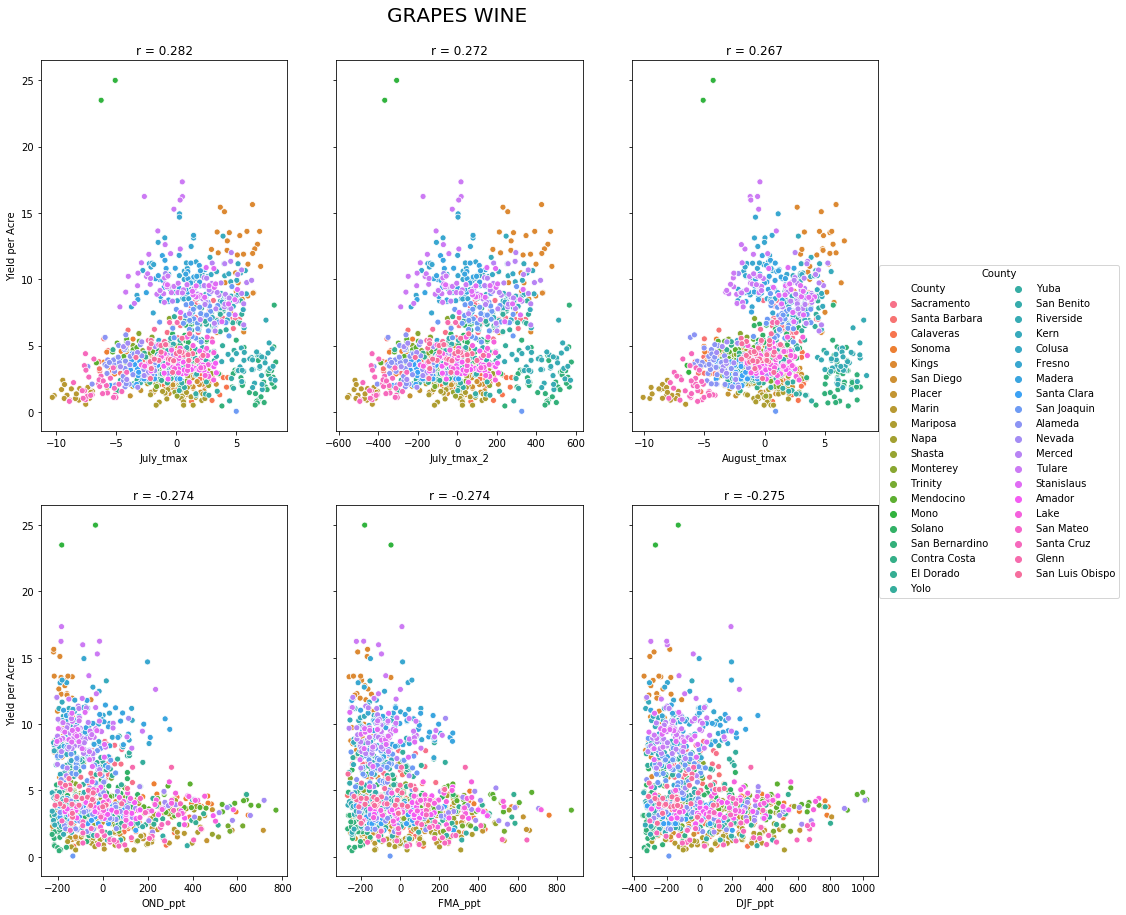

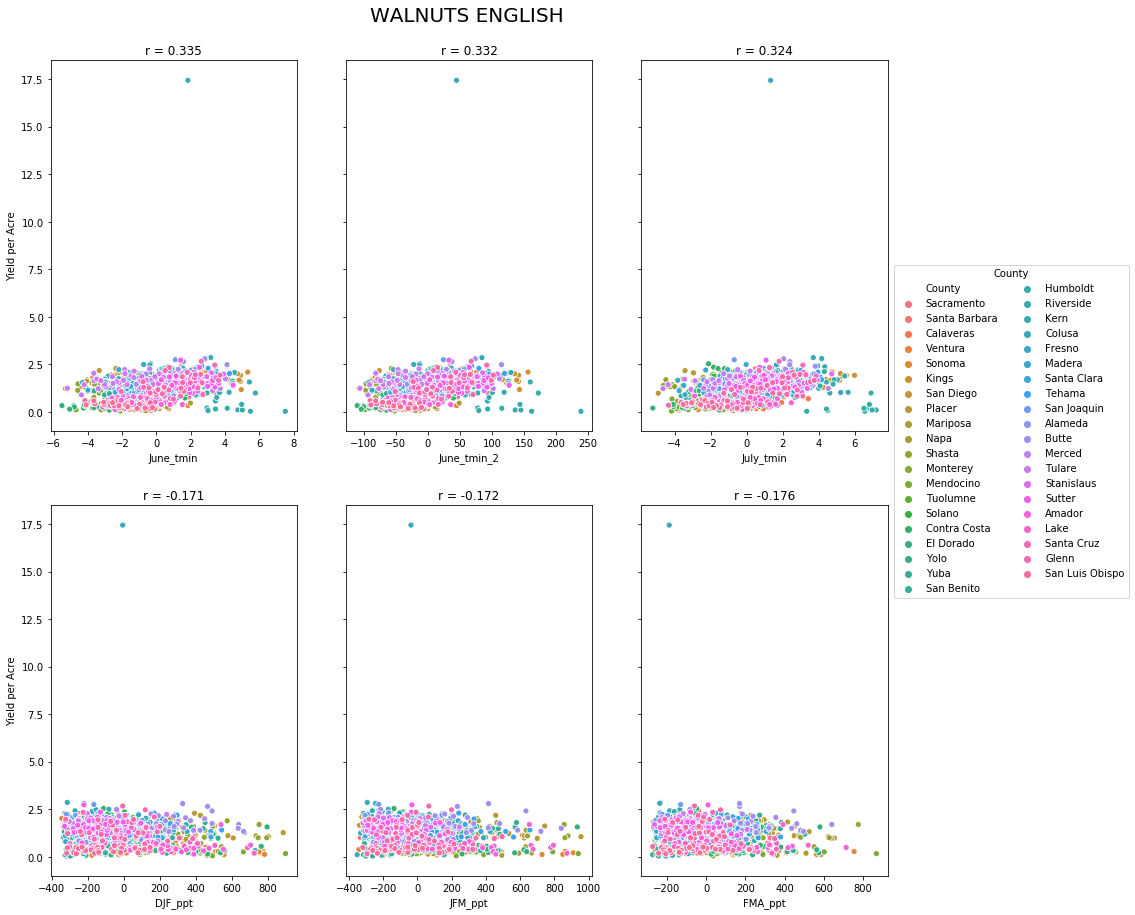

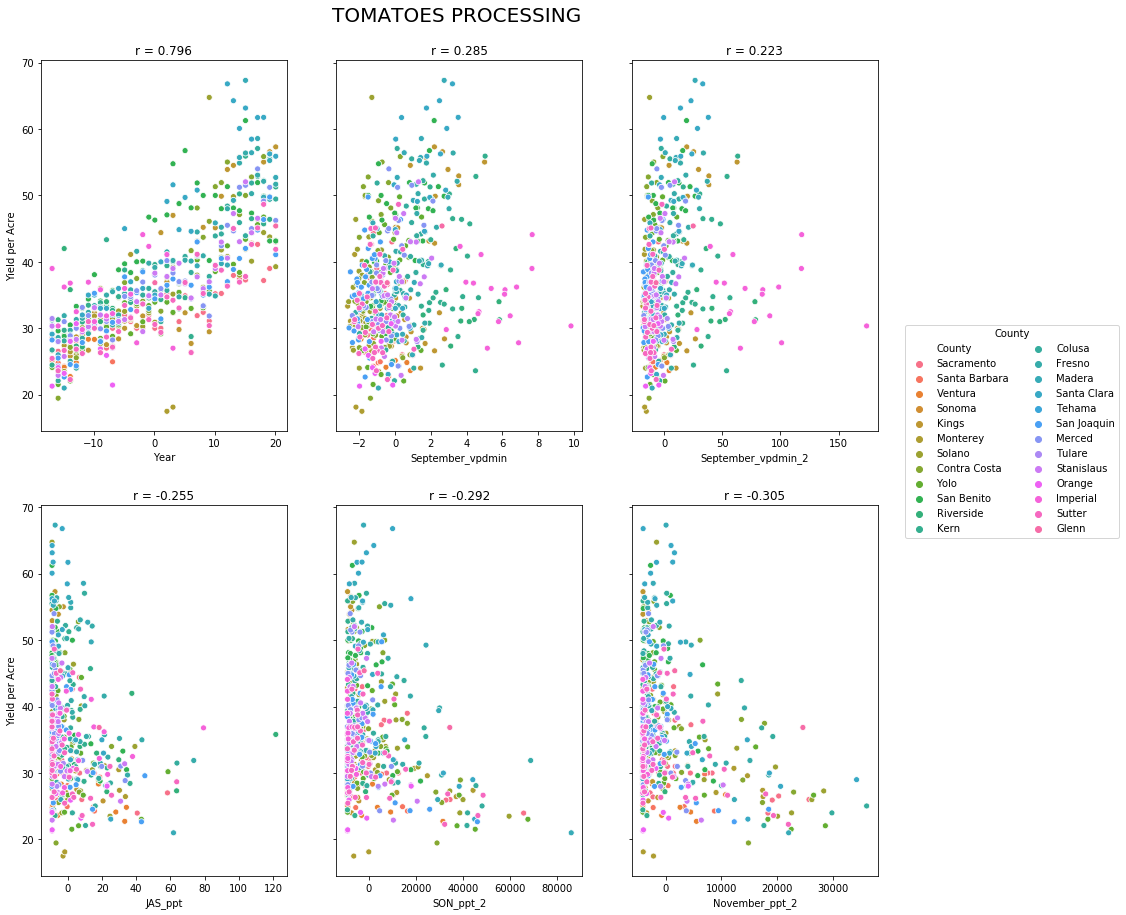

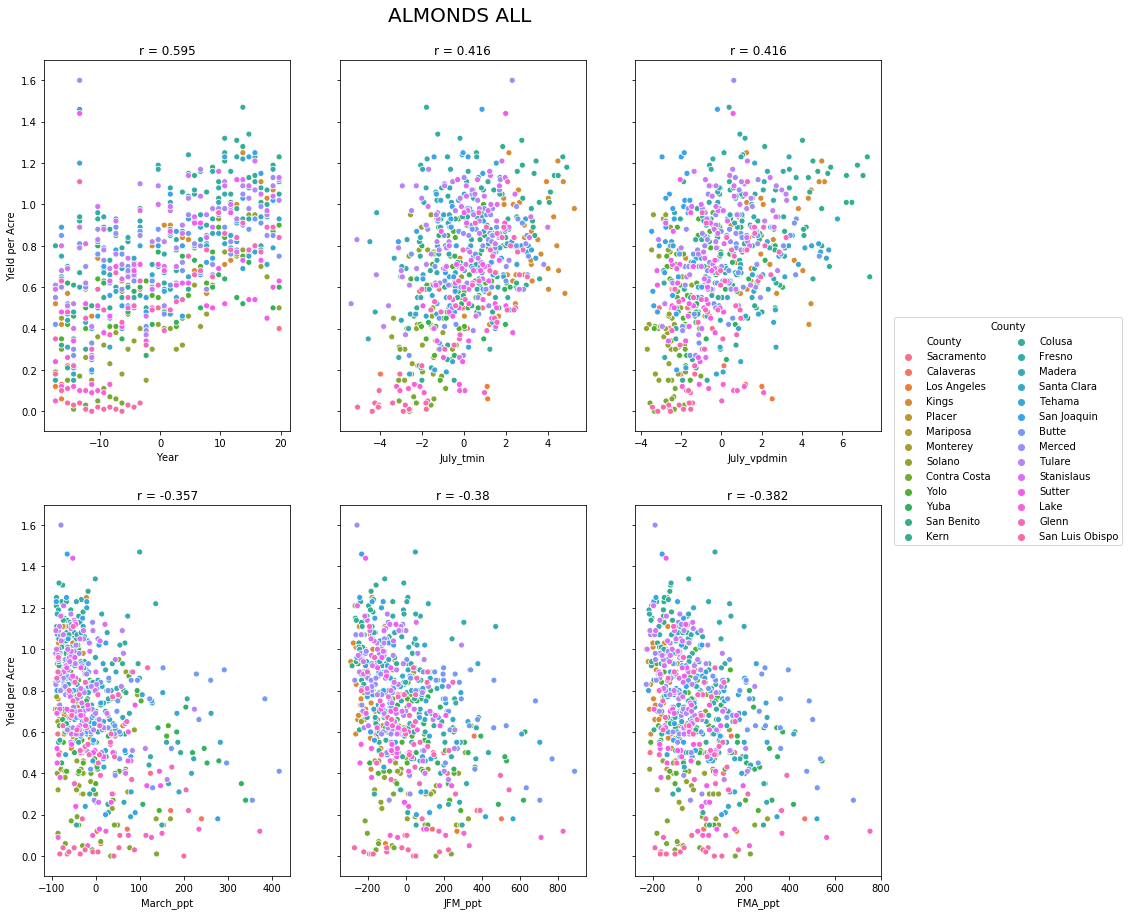

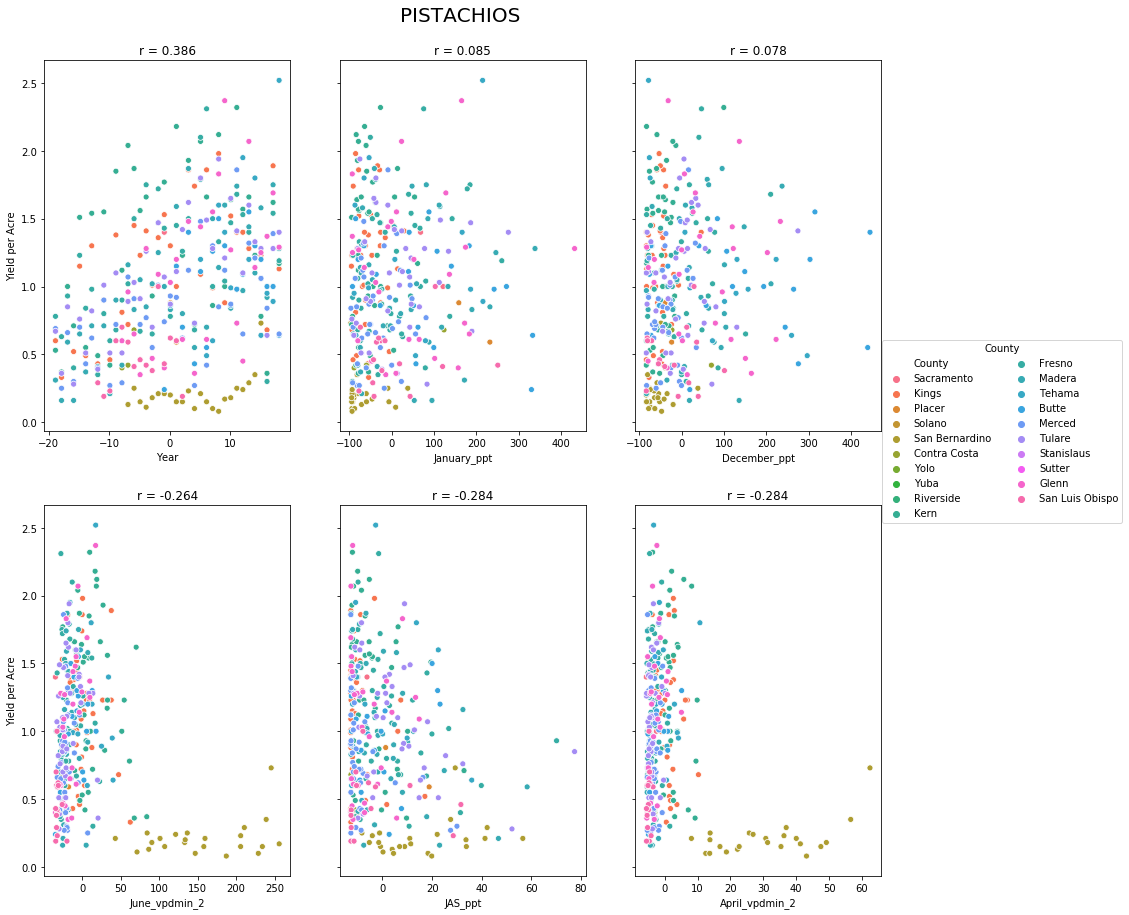

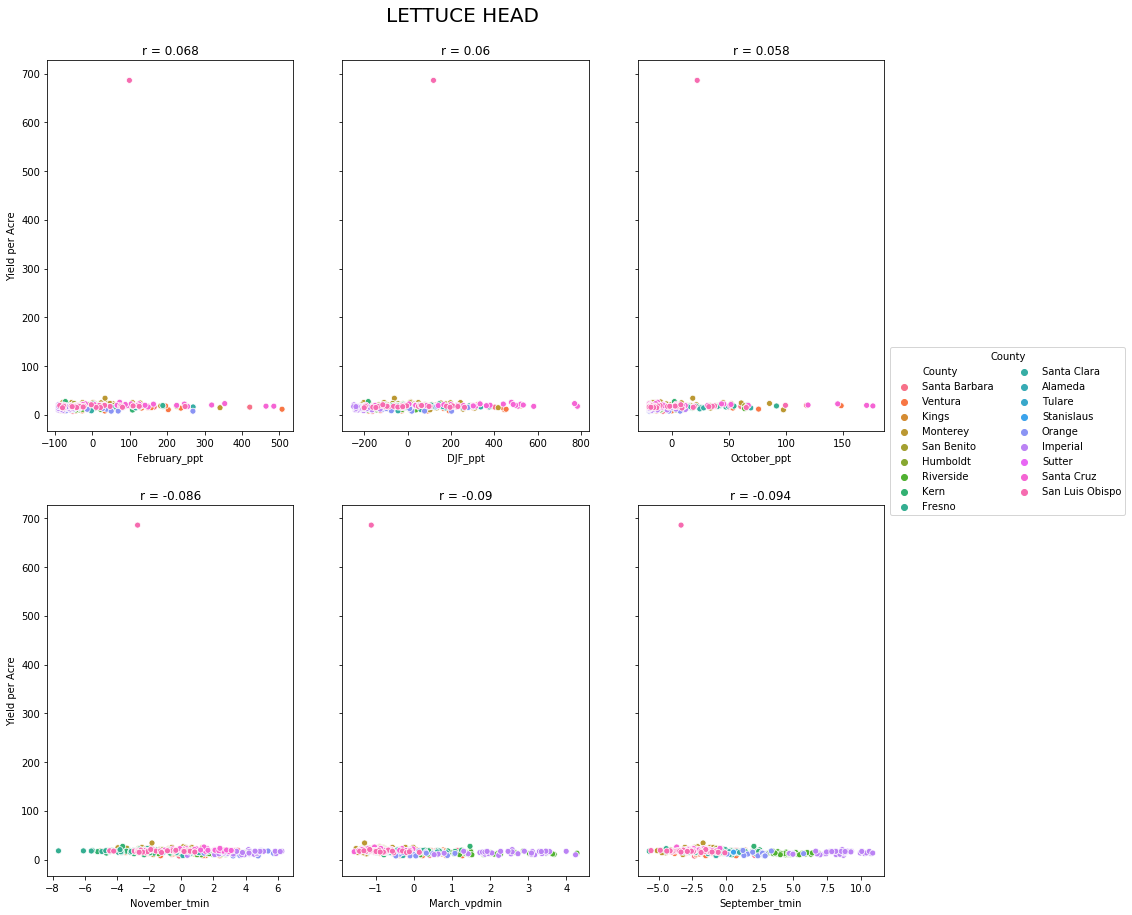

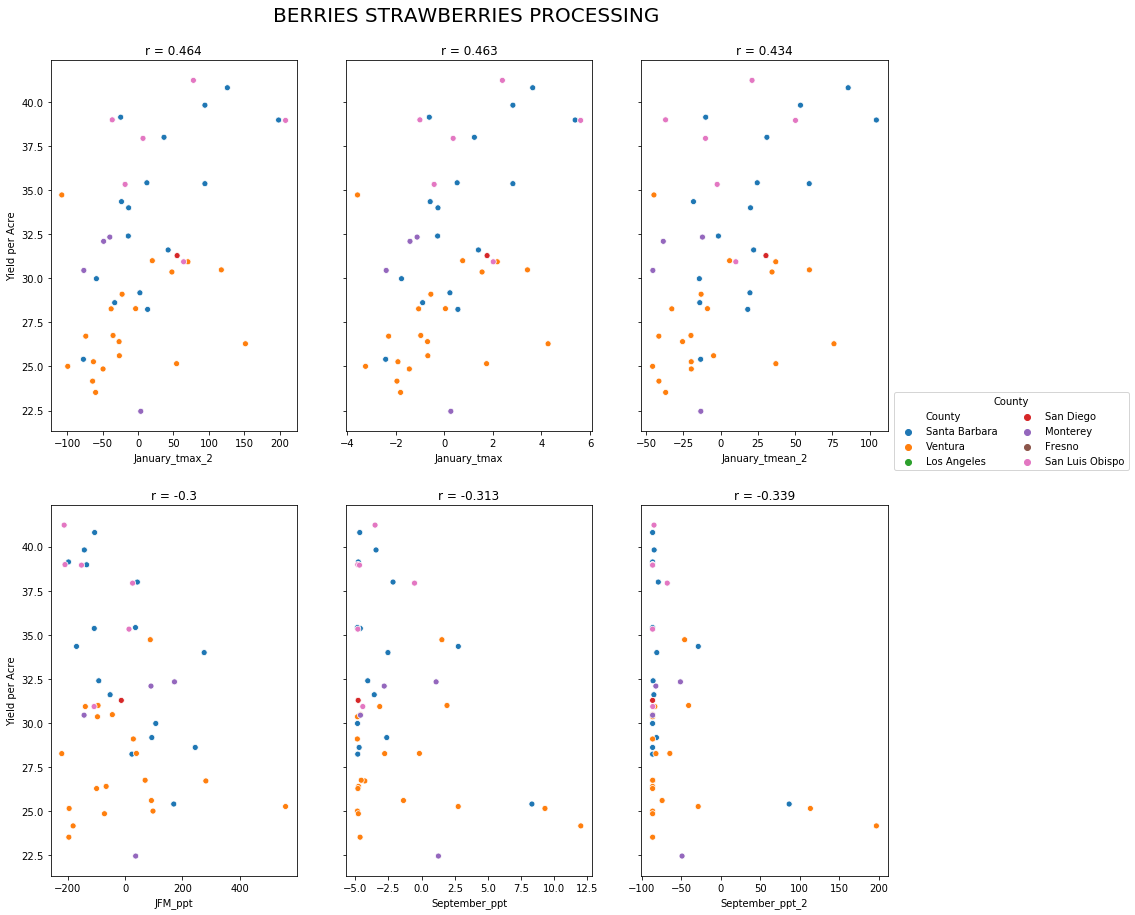

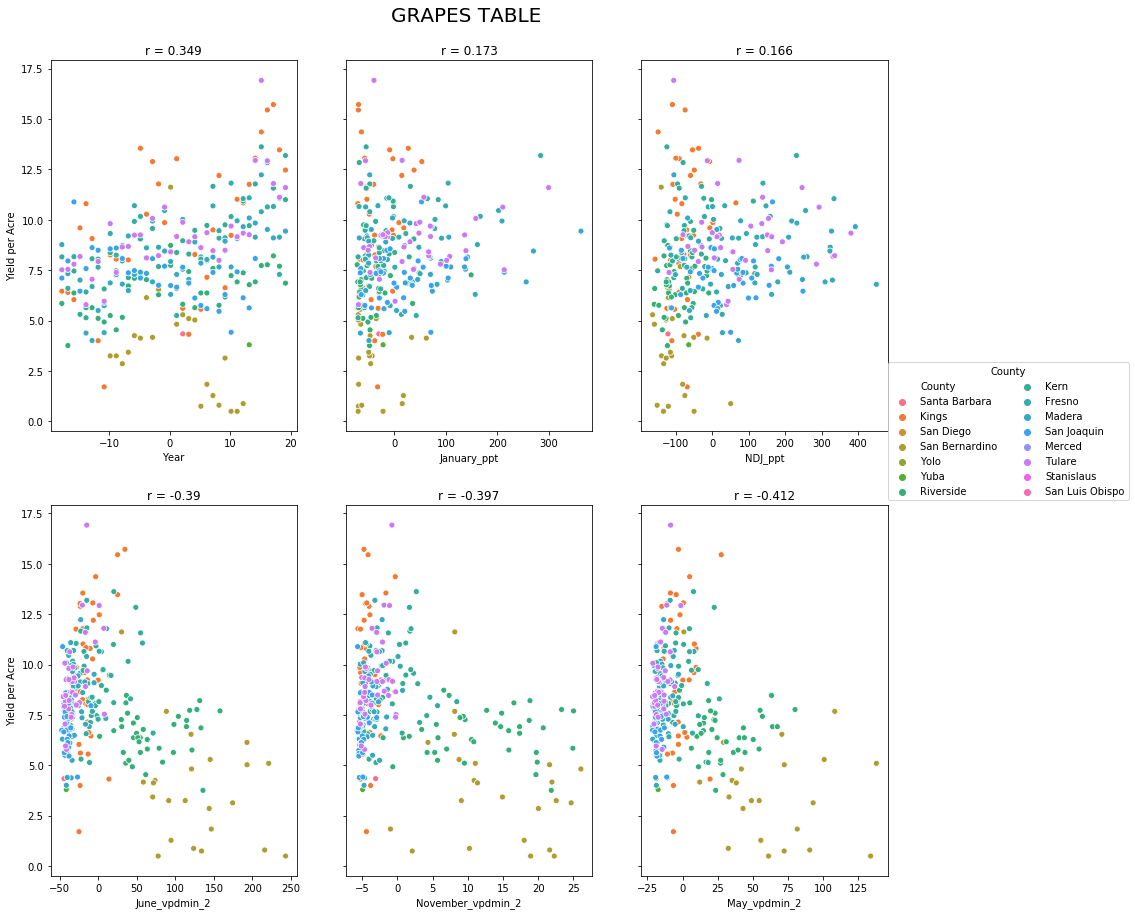

In [0]:
for crop in df_centered['Crop Name'].unique():
  
  #Filter to crop of interest
  df_crop = df_centered[df_centered['Crop Name'] == crop]
  
  #Drop unwanted columns
  df_crop = df_crop.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Production', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)
  
  #Remove rows where nan values in target field
  df_crop = df_crop[pd.notnull(df_crop['Yield per Acre'])]
  
  #Find correlation between each predictor and target
  corrs = df_crop.drop('Yield per Acre', axis=1).apply(lambda x: x.corr(df_crop['Yield per Acre']))
  
  #Store correlations as a df, sort from greatest to least
  df_corr = corrs.sort_values(ascending = False).to_frame().reset_index().rename(columns = {'index':'Variable', 0:'Corr'})
  
  #Pick out top 3 and bottom 3
  df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
  
  #Store variables as list
  vars = list(df_vars['Variable'].values)

  #Store correlations as list
  corr_values = list(df_vars['Corr'].values)
  
  #Plot scatter plots
  plot_matrix(vars, crop, corr_values)

**There are a few scatter plots where one outlier is obscuring the trend in the plot. We can plot those ones by hand.**

**WALNUTS ENGLISH**

(0, 3)

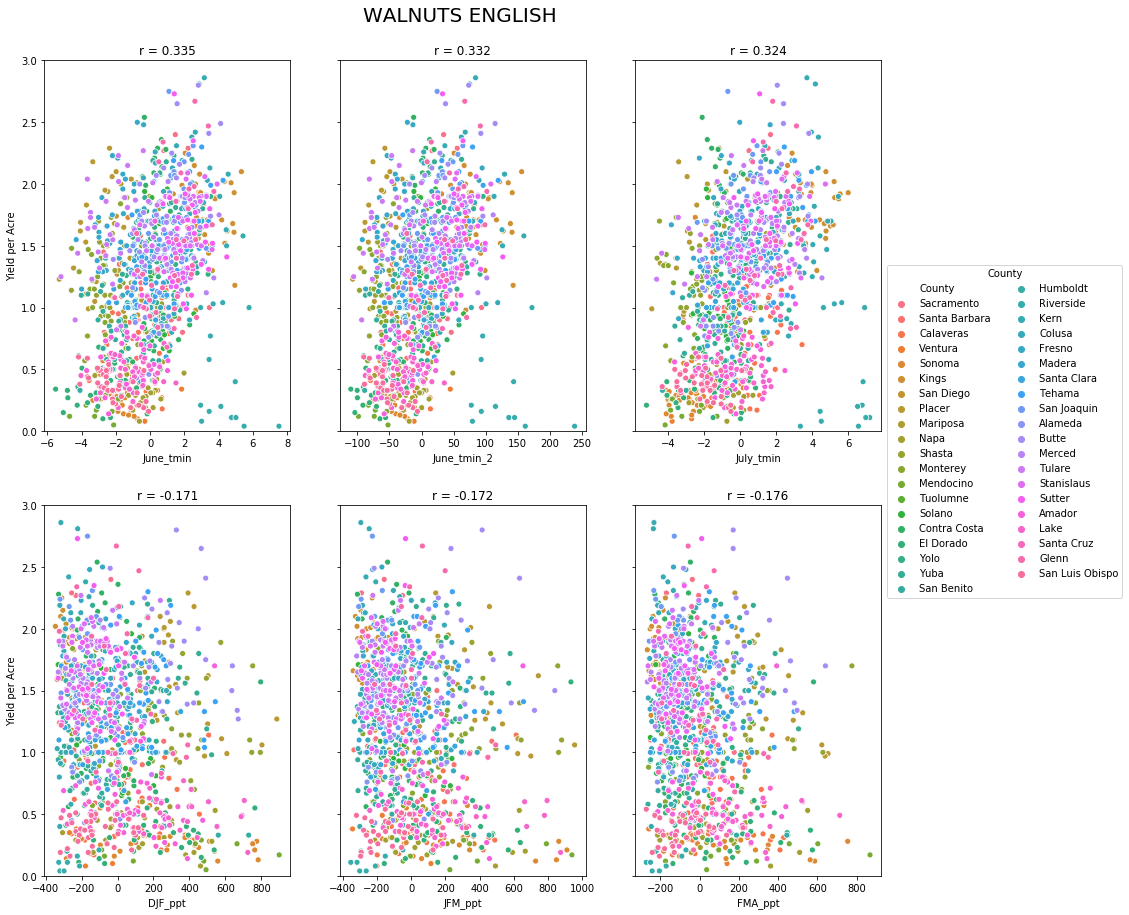

In [0]:
vars = ['June_tmin', 'June_tmin_2', 'July_tmin', 'DJF_ppt', 'JFM_ppt', 'FMA_ppt']
corr_values = [0.335, 0.332, 0.324, -0.171, -0.172, -0.176]

df_crop = df_centered[df_centered['Crop Name'] == 'WALNUTS ENGLISH']

fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

plt.suptitle('WALNUTS ENGLISH', fontsize = 20, x = 0.51, y = 0.93)

plt.ylim(0,3)

# Cross Validation By LeaveOneGroupOut

Split data into 4 folds. Divide into train and test. Specify all alphas. Run model for each alpha, save the MSE. Find average MSE over all folds for each alpha. Alpha with lowest mean MSE is the winner.

In [0]:
#Filter down df that includes fixed effect of all crops to just almonds
df_almonds = df_weather_yield[df_weather_yield['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

#Grab a list of the counties
almond_counties = df_almond_model['County'].unique()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#Create scaler object
scaler = StandardScaler()

#Make a series of counties and yield per acre
almond_no_scale = df_almond_model[['County', 'Yield per Acre']].reset_index(drop = True)

#Save a df of the years for later
almonds_years = df_almond_model[['Year']].reset_index(drop = True).rename(columns = {'Year':'Unscaled Year'})

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_array = scaler.fit_transform(df_almond_model.drop(columns = ['County', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almond_model.drop(columns = ['County', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

#Add the years back in
almond_scaled = almond_scaled.join(almonds_years)

In [0]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(almond_scaled['County'])

#Concat them to original df and rename to preserve original
almond_scaled_fixed = pd.concat([almond_scaled.drop(columns = 'County'), dummy_counties], axis = 1)
almond_scaled_fixed.head()

Year  January_ppt  January_tmax  ...  Tulare  Yolo  Yuba
0 -0.418543     1.191745     -0.310438  ...       0     0     0
1 -0.328376    -0.575816      0.694813  ...       0     0     0
2 -0.238210     1.877633      0.461393  ...       0     0     0
3 -0.148043     0.007932      0.367351  ...       0     0     0
4 -0.057876     1.100601      0.188173  ...       0     0     0

[5 rows x 193 columns]

In [0]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = almond_scaled_fixed['Yield per Acre']
X = almond_scaled_fixed.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 192) (461,)
(198, 192) (198,)


In [0]:
def grouper(x):
  if x <= 1988:
    return 1
  elif x > 1988 and x <=1997:
    return 2
  elif x > 1997 and x <= 2007:
    return 3
  elif x > 2007:
    return 4

X_train['CV Group'] = almond_scaled_fixed['Unscaled Year'].apply(grouper)
groups = X_train['CV Group'].values

#Now drop the unscaled years and CV groups on both training and testing because
#they are not features
X_train = X_train.drop(columns = ['Unscaled Year', 'CV Group'])
X_test = X_test.drop(columns = ['Unscaled Year'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import linear_model
from sklearn.linear_model import LassoCV


X = X_train.reset_index(drop = True)
y = Y_train.reset_index(drop = True)

logo = LeaveOneGroupOut()

gen_logo = logo.split(X, groups = groups)
lassoCV = LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv=gen_logo, normalize=False, random_state=9)  # pass it to the cv argument
lassoCV.fit(X, y)

LassoCV(alphas=None, copy_X=True,
        cv=<generator object BaseCrossValidator.split at 0x7fddc1b91e08>,
        eps=0.0001, fit_intercept=True, max_iter=200000, n_alphas=400,
        n_jobs=None, normalize=False, positive=False, precompute='auto',
        random_state=9, selection='cyclic', tol=0.0001, verbose=False)

In [0]:
#Check that both the training and testing sets have the same number of features
print(Y_test.shape, X_test.shape)
print(Y_train.shape, X_train.shape)

(198,) (198, 191)
(461,) (461, 191)


In [0]:
#Use lassoCV params in lasso model
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

NameError: ignored

In [0]:
features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
features_filtered = features[features['Coef'] != 0]
features_filtered = features_filtered.sort_values(by = 'Coef', ascending = False)

In [0]:
features_filtered.tail(10)

In [0]:
#how to filter features to just counties or just weather
features_filtered[~features_filtered['Features'].isin(almond_counties)]

In [0]:
almond_counties

In [0]:
from sklearn import linear_model

# Lasso Model Function

**Grouper function used to sort observations into groups for LeaveOneGroupOut cross validation.**

In [0]:
def grouper(x):
  if x <= 1988:
    return 1
  elif x > 1988 and x <=1997:
    return 2
  elif x > 1997 and x <= 2007:
    return 3
  elif x > 2007:
    return 4

In [0]:
def crop_model(crop):
  ####DATA MUNGING####
  #Filter down complete dataset to crop of interest
  df_crop = df_weather_yield[df_weather_yield['Crop Name'] == crop]

  #Drop non-essential columns
  df_crop_model = df_crop.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

  #Make sure all NaN values are removed
  df_crop_model = df_crop_model[pd.notnull(df_crop_model['Yield per Acre'])]

  #Preserve a list of the counties
  crop_counties = df_crop_model['County'].unique()

  ###SCALE DATA###
  #Create scaler object
  scaler = StandardScaler()

  #Preserve a copy of counties and yield per acre. Don't want these scaled
  crop_no_scale = df_crop_model[['County', 'Yield per Acre']].reset_index(drop = True)

  #Preserve a copy of unscaled years and rename it
  crop_years = df_crop_model[['Year']].reset_index(drop = True).rename(columns = {'Year':'Unscaled Year'})

  #Fit and transform the data (now an array). Remove columns we don't want scaled.
  scaled_array = scaler.fit_transform(df_crop_model.drop(columns = ['County', 'Yield per Acre']))

  #Convert array back to df
  scaled_df = pd.DataFrame(scaled_array, columns = df_crop_model.drop(columns = ['County', 'Yield per Acre']).columns)

  #Add the counties and yield per acre back in
  crop_scaled = scaled_df.join(crop_no_scale)

  #Add the years back in
  crop_scaled = crop_scaled.join(crop_years)

  ###FIXED EFFECTS###
  #Make dummy columns for each county growing the crop
  dummy_counties = pd.get_dummies(crop_scaled['County'])

  #Concat them to original df and rename to preserve original
  crop_scaled_fixed = pd.concat([crop_scaled.drop(columns = 'County'), dummy_counties], axis = 1)

  ###TRAIN TEST SPLIT###
  #Y is the target, X is the predictor
  Y = crop_scaled_fixed['Yield per Acre']
  X = crop_scaled_fixed.drop(['Yield per Acre'], axis = 1)

  #30% test, 70% train
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

  #Make sure the data is the right shape
  print(X_train.shape, Y_train.shape)
  print(X_test.shape, Y_test.shape)

  ###CROSS VALIDATION###

  #Apply grouper function to unscaled years
  X_train['CV Group'] = crop_scaled_fixed['Unscaled Year'].apply(grouper)

  #Save groups for CV
  groups = X_train['CV Group'].values

  #Now drop the unscaled years and CV groups on both training and testing because
  #they are not features
  X_train = X_train.drop(columns = ['Unscaled Year', 'CV Group'])
  X_test = X_test.drop(columns = ['Unscaled Year'])

  #Reset index position of training data for readability
  X = X_train.reset_index(drop = True)
  y = Y_train.reset_index(drop = True)

  #Create LeaveOneGroupOut iterator for CV
  logo = LeaveOneGroupOut()
  gen_logo = logo.split(X, groups = groups)

  ###LASSO MODEL###
  #LassoCV to get parameters
  lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv=gen_logo, normalize=False, fit_intercept = True)  # pass it to the cv argument
  lassoCV.fit(X, y)

  ####Create lasso object
  lasso = Lasso(max_iter = 200000, normalize = False, fit_intercept = True)

  #Run Lasso model with alpha value from CV
  lasso.set_params(alpha=lassoCV.alpha_)
  lasso.fit(X_train, Y_train)

  ###GOODNESS OF FIT###
  MSE_train = mean_squared_error(Y_train, lasso.predict(X_train))
  print('MSE on train set for ' + str(crop) + ':', mean_squared_error(Y_train, lasso.predict(X_train)))

  MSE_test = mean_squared_error(Y_test, lasso.predict(X_test))
  print('MSE on test set for ' + str(crop) + ':' , mean_squared_error(Y_test, lasso.predict(X_test)))

  R2_train = r2_score(Y_train, lasso.predict(X_train))
  print('R2 on train set for ' + str(crop) +':', r2_score(Y_train, lasso.predict(X_train)))

  R2_test = r2_score(Y_test, lasso.predict(X_test))
  print('R2 on test set for ' + str(crop) + ':', r2_score(Y_test, lasso.predict(X_test)))

  ###COEFFICIENT TABLES###
  #How many total features
  features = pd.DataFrame({'Features': X_train.columns.values, 'Coef': lasso.coef_})
  print('There were ' + str(features.shape[0]) + ' potential predictors for ' +str(crop))

  #How many non zero features?
  features_filtered = features[features['Coef'] != 0]
  print(str(features_filtered.shape[0]) + ' features have non-zero coefficients') 

  features_filtered = features_filtered.sort_values(by = 'Coef', ascending = False)

  #Return dictionary of results
  return {'Alpha':lassoCV.alpha_, 'Intercept':lassoCV.intercept_, 'MSE_train':MSE_train, 'MSE_test':MSE_test,
   'R2_train':R2_train, 'R2_test':R2_test, 'Filtered Features':features_filtered,
   'Crop Counties':crop_counties}

## Almonds

In [0]:
results = crop_model('ALMONDS ALL')

**Examine intercept**

In [0]:
results['Intercept']

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

**Determine the mean yield. Compare to intercept.**

In [0]:
test = df_weather_yield.groupby(['County','Crop Name']).mean().reset_index()
test[(test['Crop Name'] == 'ALMONDS ALL') & (test['County'] == 'Stanislaus')]['Yield per Acre']

**County Coefficients**

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Almonds: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

**Climate and Year Coefs**


In [0]:
fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Almonds: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)
plt.legend()

**How much did climate influence yield per acre**

Should Y be the predicted values or the mean observed yield?

Y = B0 + fi + (weather)

Y - (B0 + fi) = weather

In [0]:
avg_yields = df_weather_yield.groupby(['County','Crop Name']).mean().reset_index()
avg_yields = avg_yields[pd.notnull(avg_yields['Yield per Acre'])]

avg_almonds = avg_yields[avg_yields['Crop Name'] == 'ALMONDS ALL'][['County', 'Yield per Acre']]

almond_intercept = results['Intercept']

avg_almonds['Yield per Acre - Intercept'] = avg_almonds['Yield per Acre'] - almond_intercept

avg_almonds

In [0]:
avg_almonds.merge(county_coefs, how = 'left', left_on = 'County', right_on = 'Features')

## Wine Grapes

In [0]:
results = crop_model('GRAPES WINE')

**Intercept**

In [0]:
results['Intercept']

**Coef dfs**

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

In [0]:
county_coefs.shape

**County Coefficients**

In [0]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Wine Grapes: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

**Climate and Year Coef**

In [0]:
fig, ax = plt.subplots(figsize = (14,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Wine Grapes: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

In [0]:
df_weather_yield['Crop Name'].unique()

In [0]:
df_weather_yield[df_weather_yield['Crop Name'] == 'GRAPES WINE']['Yield per Acre']


## Walnuts

In [0]:
results = crop_model('WALNUTS ENGLISH')

**Intercept**

In [0]:
results['Intercept']

**Coefs dfs**

In [0]:
df = results['Filtered Features']
counties = results['Crop Counties']
climate_coefs = df[~df['Features'].isin(counties)]
county_coefs = df[df['Features'].isin(counties)]

In [0]:
county_coefs.shape

**County Coefficients**

In [0]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = county_coefs, palette = 'RdBu_r')
ax.set_title('Walnuts: County Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

**Climate and Year**

In [0]:
fig, ax = plt.subplots(figsize = (14,5))
ax = sns.barplot(x = 'Features', y = 'Coef', data = climate_coefs, palette = 'RdBu_r')
ax.set_title('Walnuts: Climate Coefficients', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Coefficient', fontsize = 16, labelpad = 15)
ax.set_xlabel('')
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)

# Winter 2020
**Almonds only**
Window cross validation:
Set aside first 10 years. Use LOGO CV to find alpha. Use alpha to predict next years.
Rinse and repeat.





In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import linear_model


In [0]:
def crop_model_data_prep(crop):
  ####DATA MUNGING####
  #Filter down complete dataset to crop of interest
  df_crop = df_weather_yield[df_weather_yield['Crop Name'] == crop]

  #Drop non-essential columns
  df_crop_model = df_crop.drop(['Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

  #Make sure all NaN values are removed
  df_crop_model = df_crop_model[pd.notnull(df_crop_model['Yield per Acre'])]

  #Preserve a list of the counties
  crop_counties = df_crop_model['County'].unique()

  ###SCALE DATA###
  #Create scaler object
  scaler = StandardScaler()

  #Preserve a copy of counties and yield per acre. Don't want these scaled
  crop_no_scale = df_crop_model[['County', 'Yield per Acre']].reset_index(drop = True)

  #Preserve a copy of unscaled years and rename it
  crop_years = df_crop_model[['Year']].reset_index(drop = True).rename(columns = {'Year':'Unscaled Year'})

  #Fit and transform the data (now an array). Remove columns we don't want scaled.
  scaled_array = scaler.fit_transform(df_crop_model.drop(columns = ['County', 'Yield per Acre']))

  #Convert array back to df
  scaled_df = pd.DataFrame(scaled_array, columns = df_crop_model.drop(columns = ['County', 'Yield per Acre']).columns)

  #Add the counties and yield per acre back in
  crop_scaled = scaled_df.join(crop_no_scale)

  #Add the years back in
  crop_scaled = crop_scaled.join(crop_years)

  ###FIXED EFFECTS###

  #Get list of counties
  counties = crop_scaled['County']

  #Make dummy columns for each county growing the crop
  dummy_counties = pd.get_dummies(crop_scaled['County'])

  #Concat them to original df and rename to preserve original
  crop_scaled_fixed = pd.concat([crop_scaled.drop(columns = 'County'), dummy_counties], axis = 1)

  return crop_scaled_fixed, counties

In [0]:
#Get cleaned up almond data and associated counties
almonds_cleaned, almond_counties = crop_model_data_prep(crop = 'ALMONDS ALL')

In [18]:
#Packages
from sklearn.metrics import r2_score
from sklearn import linear_model

import warnings
warnings.warn("once")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: once
  """


In [0]:
def grouper(x):
  if x in group_bins[0]:
    return 0
  elif x in group_bins[1]:
    return 1
  elif x in group_bins[2]:
    return 2
  elif x in group_bins[3]:
    return 3
  elif x in group_bins[4]:
    return 4

In [20]:
years = np.arange(1991,2017+1)

model_dict = {}
for year in years:
  #Set used to determine alpha for model (all but year I am predicting)
  alpha_set = almonds_cleaned[almonds_cleaned['Unscaled Year'] <= year - 1]

  #Determine the years that are in each group for CV
  group_bins = np.array_split(range(1980,year,1), 5)

  #Create array that describes which group bin each year falls into
  groups = alpha_set['Unscaled Year'].apply(grouper).values

  #Split the alpha set into predictors and target
  alpha_set_predictors = alpha_set.drop(columns = ['Unscaled Year', 'Yield per Acre'])
  alpha_set_target = alpha_set['Yield per Acre']

  #Create CV iterator for model
  logo = LeaveOneGroupOut()
  gen_logo = logo.split(alpha_set_predictors, alpha_set_target, groups = groups)

  #Create LassoCV model object with CV iterator. Fit on alpha_set data.
  lassoCV = linear_model.LassoCV(n_alphas=400, max_iter = 1000000, cv=gen_logo, normalize=False, fit_intercept = True)

  lassoCV.fit(alpha_set_predictors, alpha_set_target)

  #Create Lasso model object with alpha determined by CV. Fit on alpha_set data
  lasso = linear_model.Lasso(normalize = False, max_iter = 1000000, fit_intercept = True)
  lasso.set_params(alpha = lassoCV.alpha_)
  lasso.fit(alpha_set_predictors, alpha_set_target)

  #Set used to validate model
  validate_year = almonds_cleaned[almonds_cleaned['Unscaled Year'] == year]

  #Seperate predictors and target for validation year
  validate_year_predictors = validate_year.drop(columns = ['Unscaled Year', 'Yield per Acre'])
  validate_year_target = validate_year['Yield per Acre']
  

  ###Format output###
  ##R2
  train_R2 = np.corrcoef(alpha_set_target, lasso.predict(alpha_set_predictors))[0][1]**2
  validation_R2 = np.corrcoef(validate_year_target,lasso.predict(validate_year_predictors))[0][1]**2

  ##Observed yields
  #Get list of counties dummy columns and stack into one column
  counties = validate_year_predictors[almond_counties.unique()]
  county_series = counties.idxmax(axis=1)

  observed_yield = pd.concat([county_series, validate_year_target], axis = 1)
  observed_yield.columns = ['County', 'Observed Yield per Acre']

  ##Predicted yields

  predicted_yield = pd.concat([county_series.reset_index(drop = True), pd.Series(lasso.predict(validate_year_predictors)).reset_index(drop = True)], axis = 1)
  predicted_yield.columns = ['County', 'Predicted Yield per Acre']


  results_dict = {'TRAIN R2': train_R2,
                'VALIDATION R2': validation_R2,
                'OBSERVED YIELD/ACRE': observed_yield,
                'PREDICTED YIELD/ACRE': predicted_yield,
                'ALPHA': lassoCV.alpha_,
                'INTERCEPT': lasso.intercept_,
                'FEATURES': pd.DataFrame({'Features': alpha_set_predictors.columns.values, 'Coef': lasso.coef_})}

  model_dict[str(year)] = results_dict
  print('Predicted ' + str(year))

Predicted 1991
Predicted 1992
Predicted 1993
Predicted 1994
Predicted 1995
Predicted 1996
Predicted 1997
Predicted 1998
Predicted 1999
Predicted 2000
Predicted 2001
Predicted 2002
Predicted 2003
Predicted 2004
Predicted 2005
Predicted 2006
Predicted 2007
Predicted 2008
Predicted 2009
Predicted 2010
Predicted 2011
Predicted 2012
Predicted 2013
Predicted 2014
Predicted 2015
Predicted 2016
Predicted 2017


## Analysis of Model Results

### Trended Plot Each Year Color By County

In [0]:
#Dict of colors
county_colors = {'Sacramento': 'black',
 'Calaveras': 'silver',
 'Los Angeles': 'rosybrown',
 'Kings': 'firebrick',
 'Placer': 'salmon',
 'Mariposa': 'coral',
 'Monterey': 'sienna',
 'Solano': 'sandybrown',
 'Contra Costa': 'gold',
 'Yolo': 'olive',
 'Yuba': 'darkseagreen',
'San Benito': 'forestgreen',
 'Kern': 'mediumaquamarine',
 'Colusa': 'darkslategrey',
 'Fresno': 'aqua',
 'Madera': 'dodgerblue',
 'Santa Clara': 'navy',
       'Tehama': 'rebeccapurple',
  'San Joaquin': 'thistle',
  'Butte': 'hotpink',
  'Merced': 'pink',
 'Tulare': 'wheat',
 'Stanislaus': 'darkgoldenrod',
  'Sutter': 'orangered',
  'Lake': 'saddlebrown',
  'Glenn': 'khaki',
  'San Luis Obispo': 'lightskyblue'}

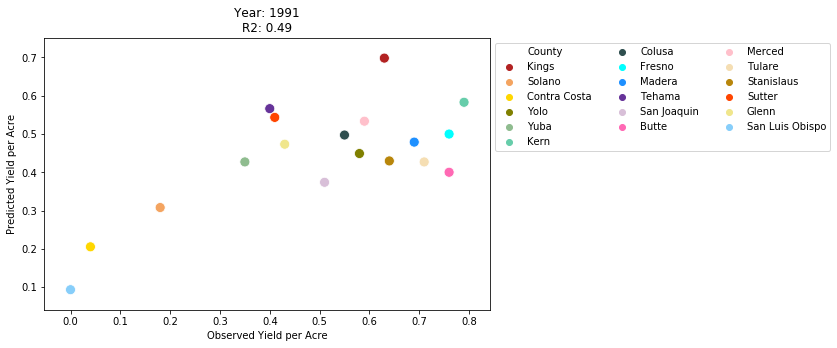

In [22]:
observed = model_dict['1991']['OBSERVED YIELD/ACRE']
predicted = model_dict['1991']['PREDICTED YIELD/ACRE']
#Is this even the right R2
validation_R2 = model_dict['1991']['VALIDATION R2']

df = pd.merge(left = observed, right = predicted, how = 'inner', on = 'County')

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Observed Yield per Acre', y = 'Predicted Yield per Acre', data = df, s = 100, hue = 'County', palette = county_colors)
ax.set_title('Year: 1991\n' + 'R2: ' + str(round(validation_R2,2)))
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


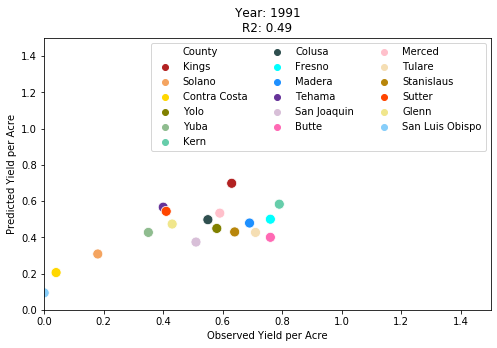

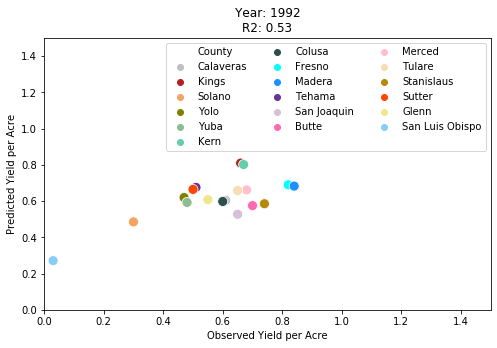

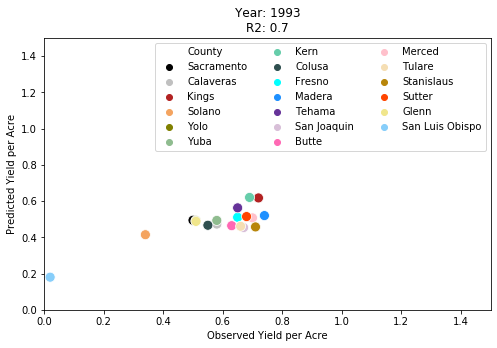

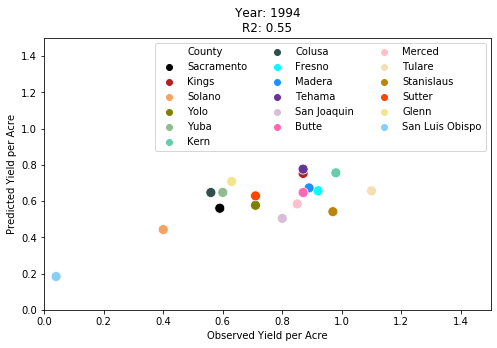

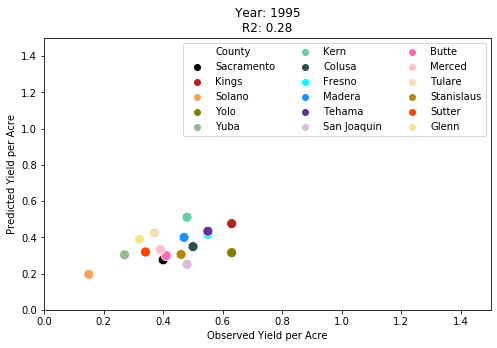

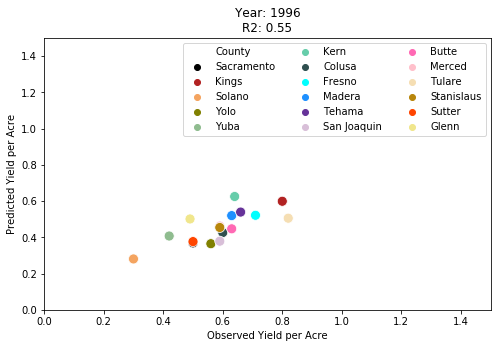

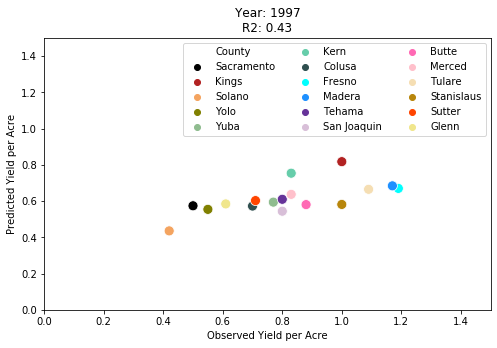

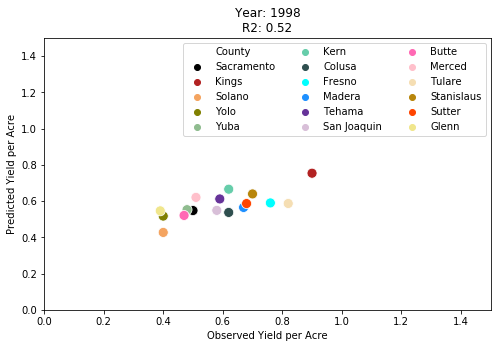

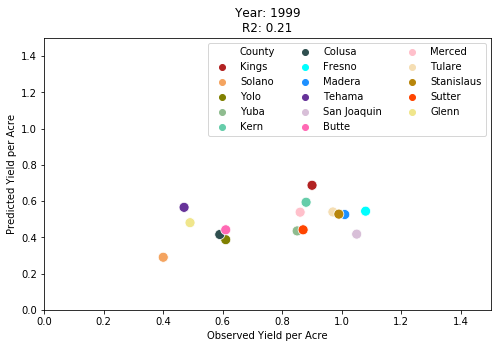

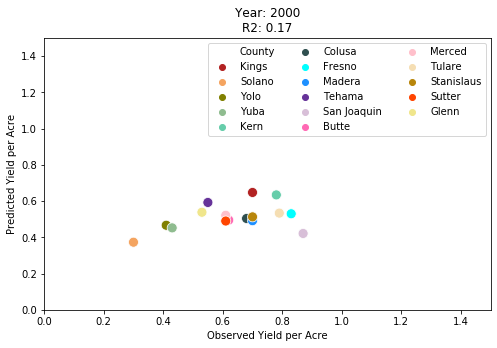

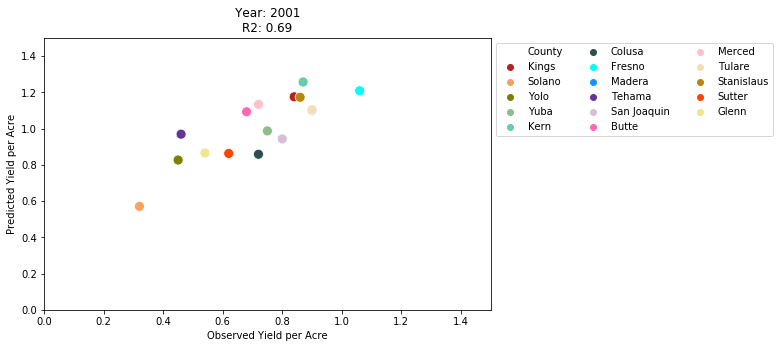

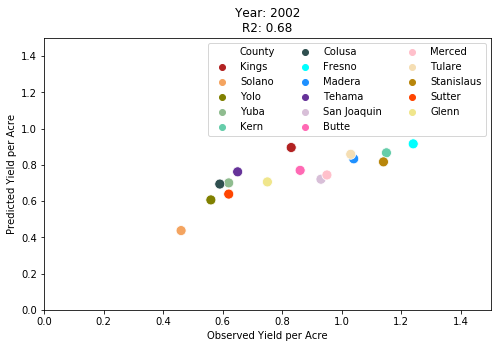

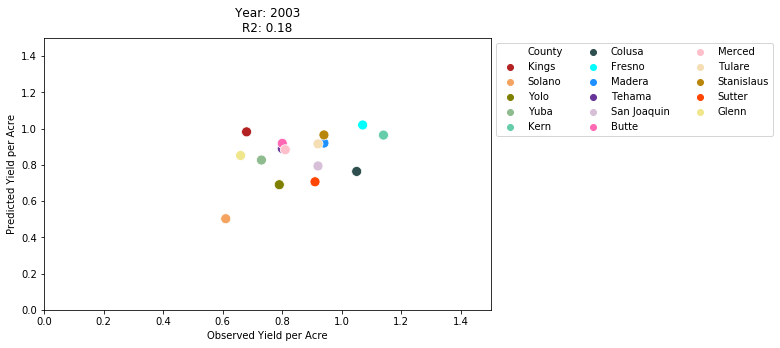

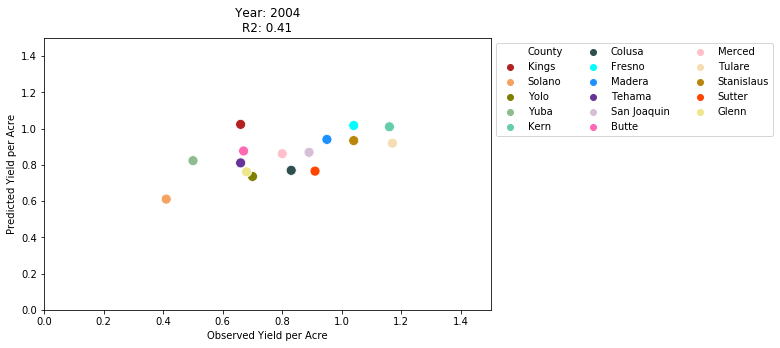

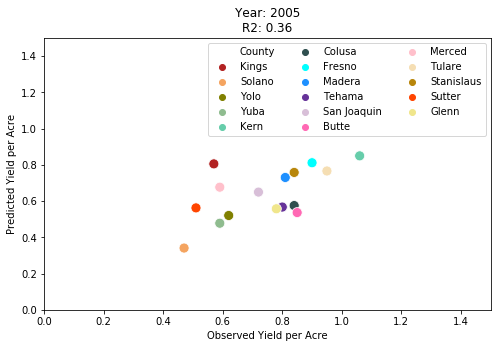

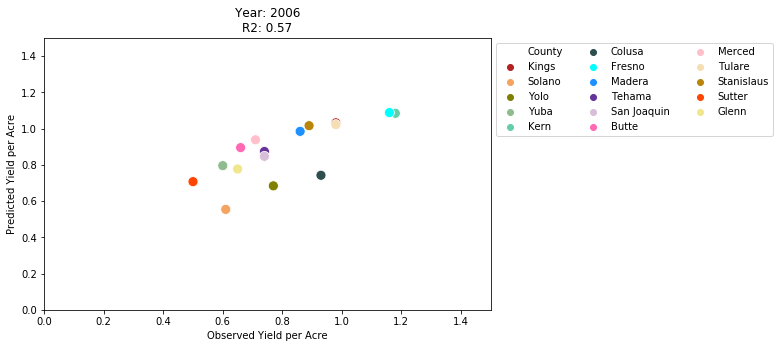

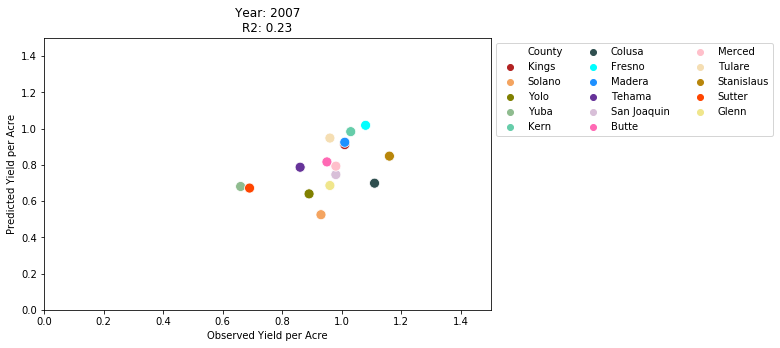

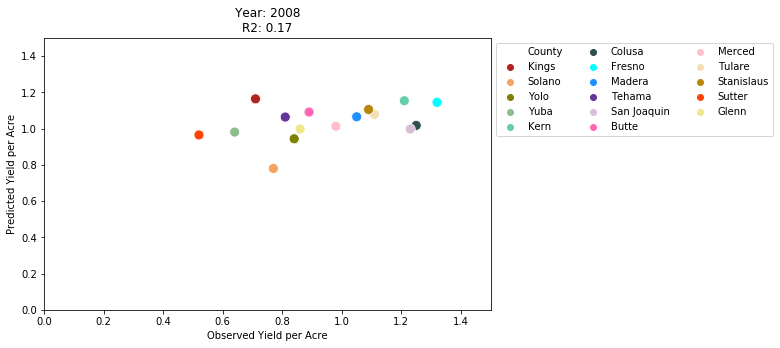

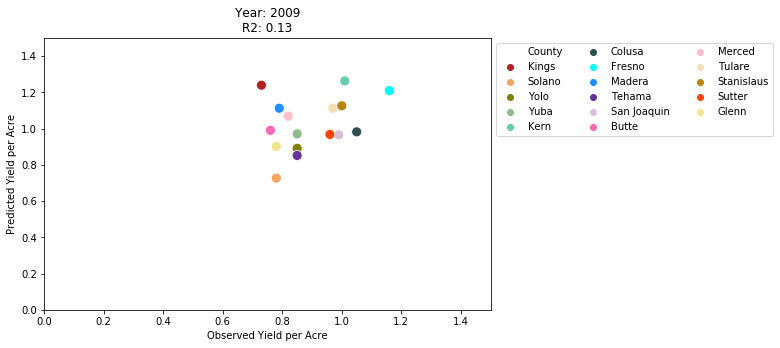

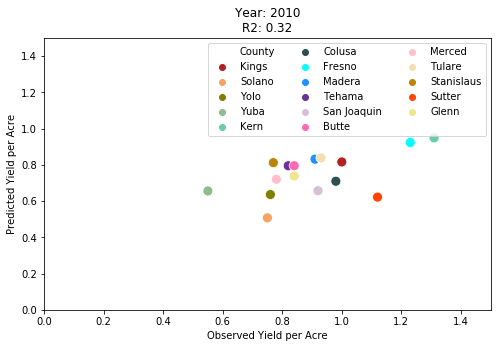

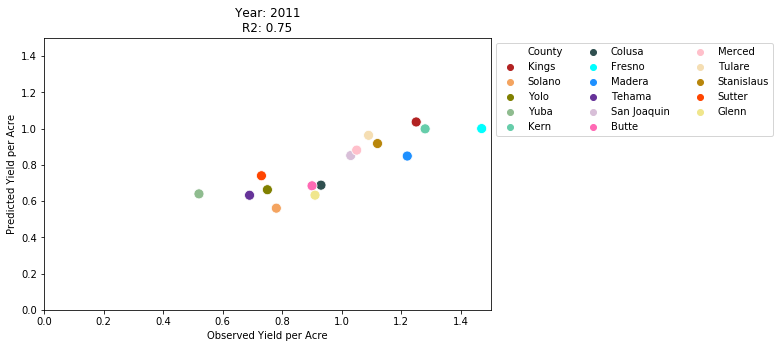

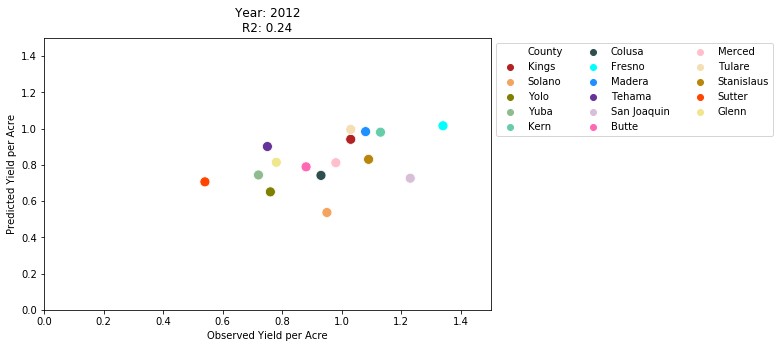

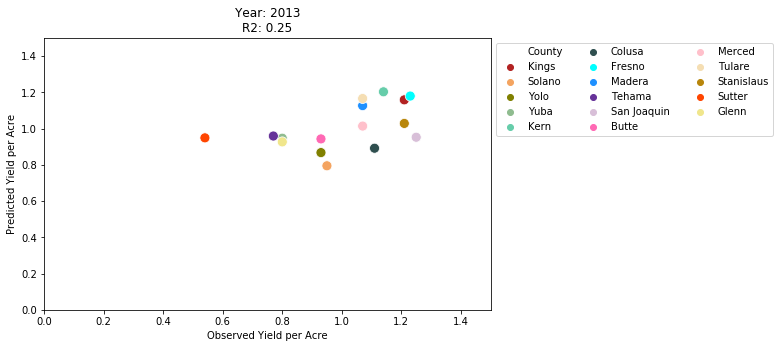

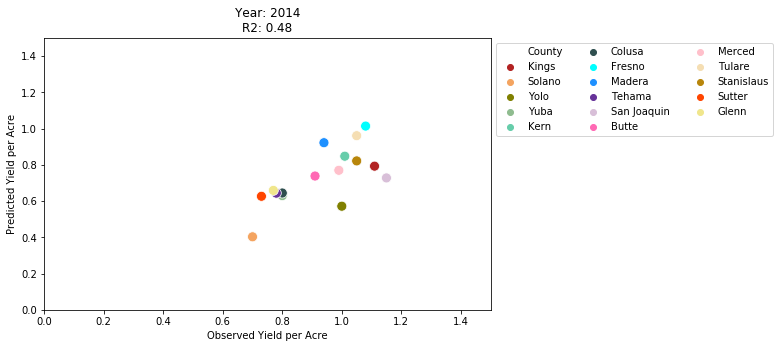

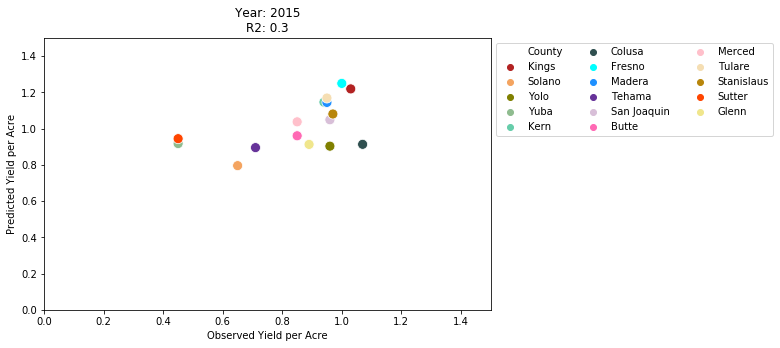

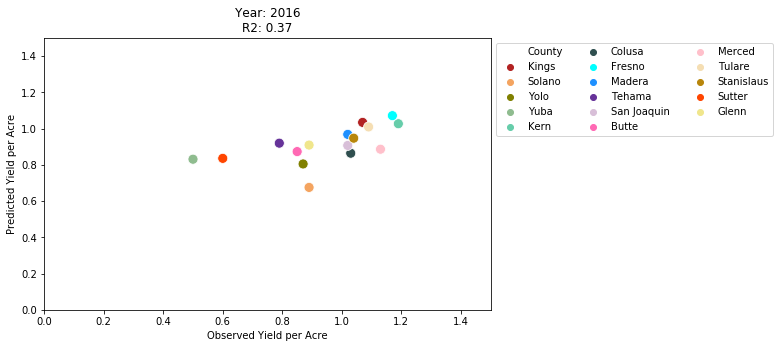

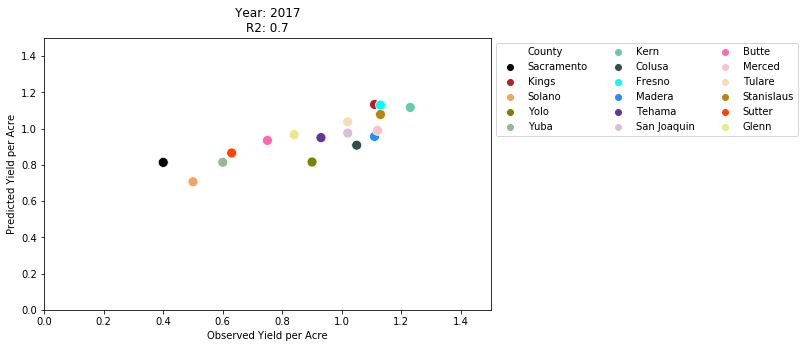

In [23]:
for year in np.arange(1991,2017+1):
  observed = model_dict[str(year)]['OBSERVED YIELD/ACRE']
  predicted = model_dict[str(year)]['PREDICTED YIELD/ACRE']
  validation_R2 = model_dict[str(year)]['VALIDATION R2']

  df = pd.merge(left = observed, right = predicted, how = 'inner', on = 'County')

  fig, ax = plt.subplots(figsize = (8,5))
  ax = sns.scatterplot(x = 'Observed Yield per Acre', y = 'Predicted Yield per Acre', data = df, s= 100, hue = 'County', palette = county_colors)
  ax.set_ylim(0,1.5)
  ax.set_xlim(0,1.5)
  ax.set_title('Year: ' + str(year) + '\nR2: ' + str(round(validation_R2,2)))
  plt.legend(bbox_to_anchor = (1,1), ncol = 3)

###Trended Plot Each County Color By Year

In [0]:
df_list = []
for year in np.arange(1991,2017+1):
  observed = model_dict[str(year)]['OBSERVED YIELD/ACRE']
  predicted = model_dict[str(year)]['PREDICTED YIELD/ACRE']

  df = pd.merge(left = observed, right = predicted, how = 'inner', on = 'County')
  df['Year'] = year
  df_list.append(df)

county_yields = pd.concat(df_list)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


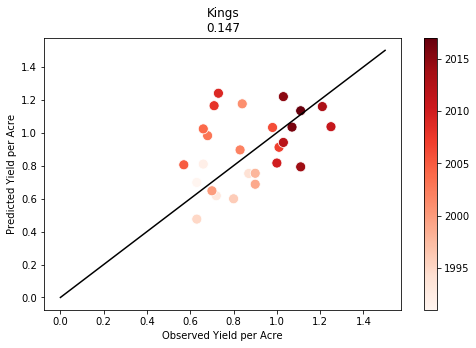

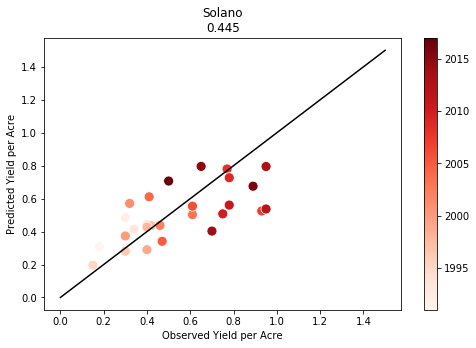

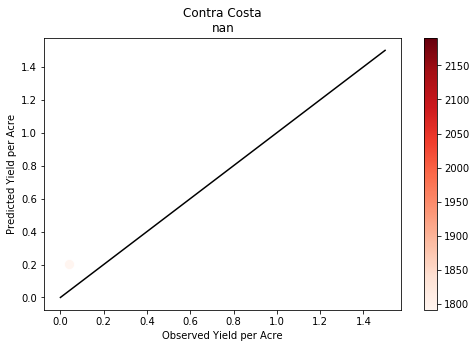

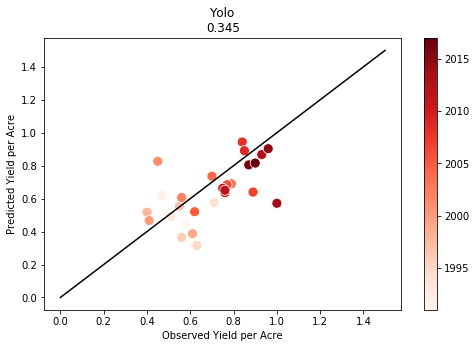

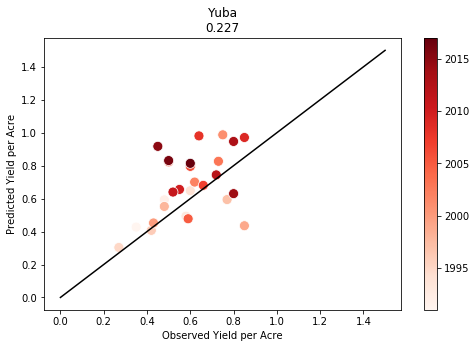

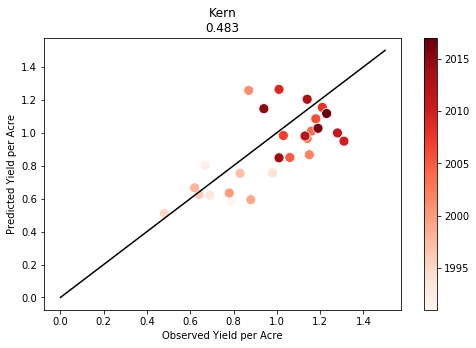

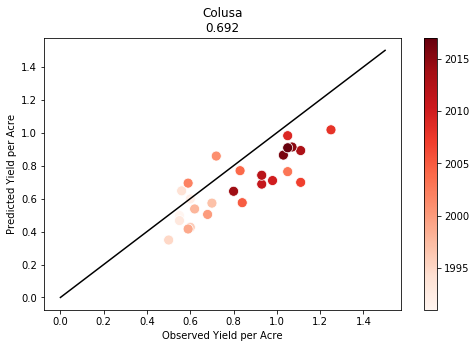

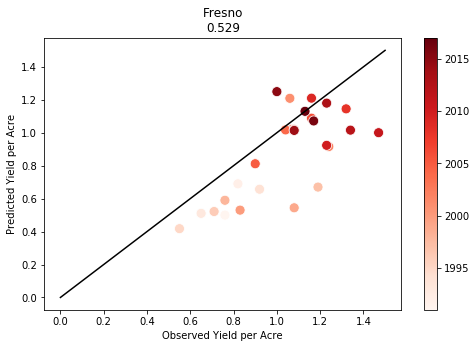

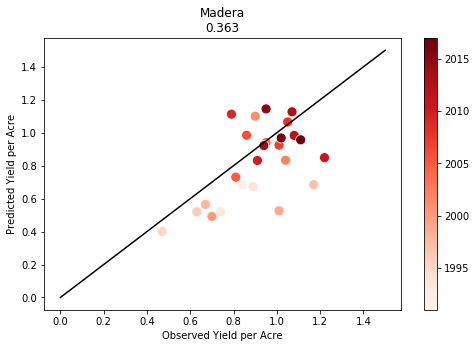

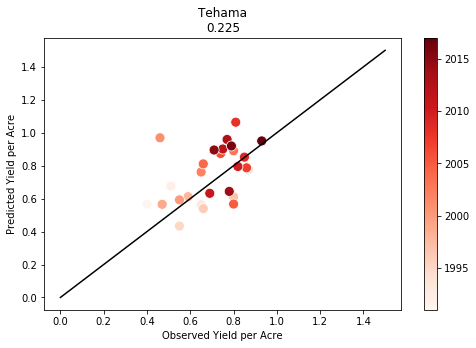

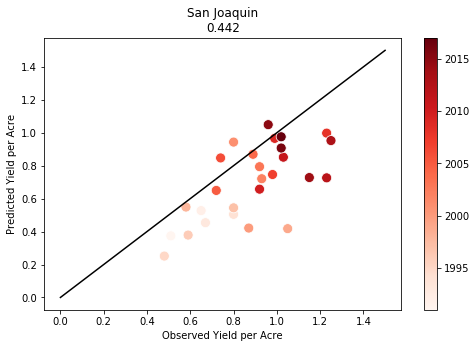

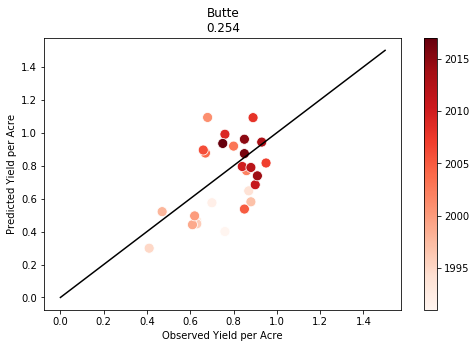

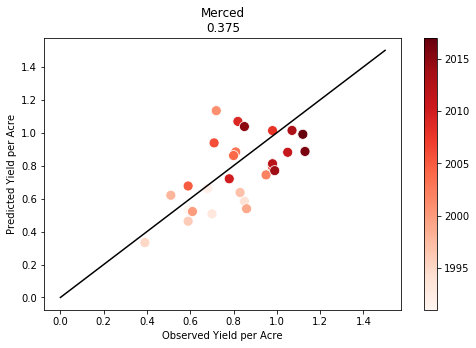

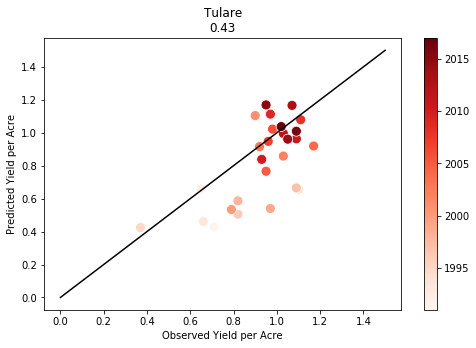

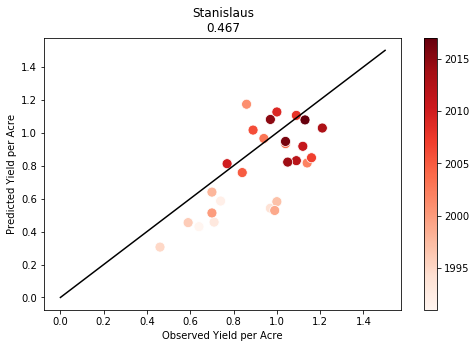

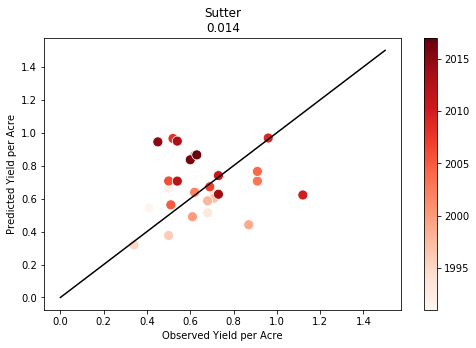

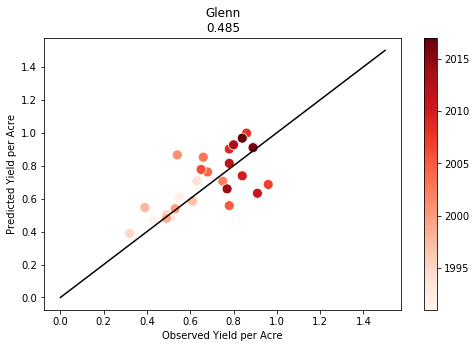

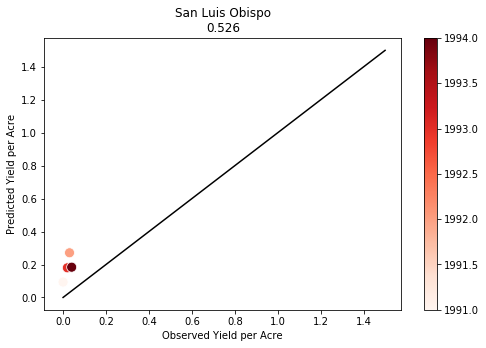

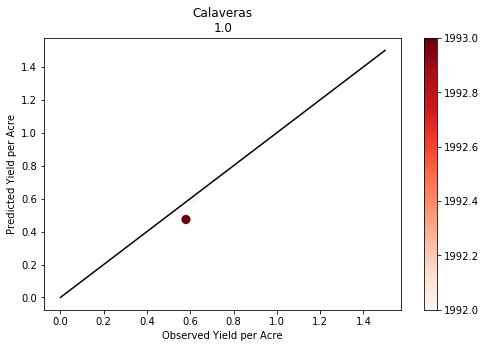

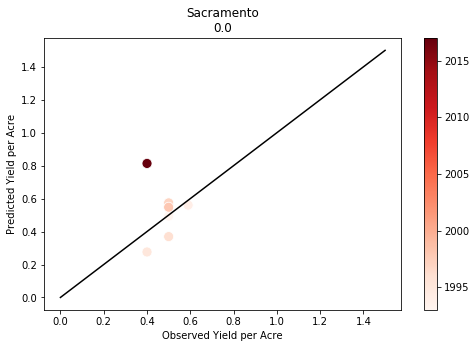

In [25]:
counties = county_yields['County'].unique()
county_R2 = {}

for county in counties:

  #Filter
  county_df = county_yields[county_yields['County'] == county]

  #Create colorbar
  norm = plt.Normalize(county_df['Year'].min(), county_df['Year'].max())
  sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
  sm.set_array([])

  #Plot
  fig, ax = plt.subplots(figsize = (8,5))
  ax = sns.scatterplot(x = 'Observed Yield per Acre', y = 'Predicted Yield per Acre', data = county_df, s = 100, hue = 'Year', palette = 'Reds')
  plt.legend(ncol = 3, bbox_to_anchor = (1,1))

  #1:1 line
  x = [0.0, 0.5, 1.5]
  y = [0.0, 0.5, 01.5]
  plt.plot(x,y, color = 'black')

  #R2 and observations
  R2 = np.corrcoef(county_df['Observed Yield per Acre'], county_df['Predicted Yield per Acre'])[0][1]**2
  observations = county_df.shape[0]

  #Title
  ax.set_title(county + '\n' + str(round(R2,3)))

  #Color bar
  ax.get_legend().remove()
  ax.figure.colorbar(sm)

  #Store in dict for later
  county_R2[county] = [R2, observations]

In [0]:
R2_countymap = pd.DataFrame(county_R2).T.rename(columns = {0:'R2', 1:'Observations'})
R2_countymap.to_csv('R2_countymap.csv')

### Plot R2 Validation for Each Year

In [0]:
#Dict to collect year:R2 key:value pair
validationR2 = {}

#Loop through years
for year in np.arange(1991,2017+1):
  validationR2[year] = model_dict[str(year)]['VALIDATION R2']

Text(0.5, 0, 'Year')

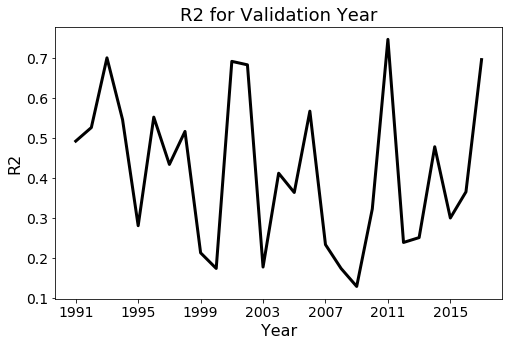

In [28]:
df_validationR2 = pd.Series(validationR2).to_frame(name = 'R2')
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.lineplot(x = df_validationR2.index, y = 'R2', data = df_validationR2, color = 'black', linewidth = 3)

#Format ticks
ax.set_xticks(np.arange(1991, 2017, 4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#Format axis labels
ax.set_title('R2 for Validation Year', fontsize = 18)
ax.set_ylabel('R2', fontsize = 16)
ax.set_xlabel('Year', fontsize = 16)

###Plot R2 Training Set Each Year

Text(0.5, 0, 'Validation Year')

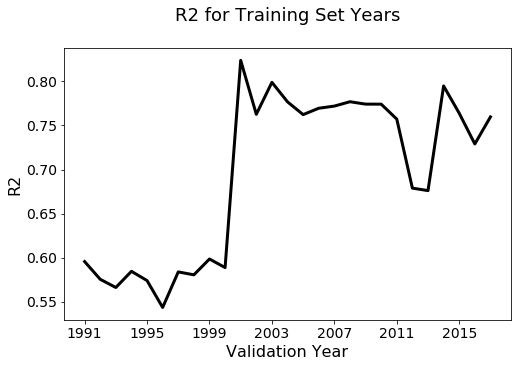

In [29]:
#Dict to collect year:R2 key:value pair
trainR2 = {}

#Loop through years
for year in np.arange(1991,2017+1):
  trainR2[year] = model_dict[str(year)]['TRAIN R2']

df_trainR2 = pd.Series(trainR2).to_frame(name = 'R2')
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.lineplot(x = df_trainR2.index, y = 'R2', data = df_trainR2, color = 'black', linewidth = 3)

#Format ticks
ax.set_xticks(np.arange(1991, 2017, 4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#Format axis labels
ax.set_title('R2 for Training Set Years\n', fontsize = 18)
ax.set_ylabel('R2', fontsize = 16)
ax.set_xlabel('Validation Year', fontsize = 16)

Text(0.5, 0, 'Validation Year')

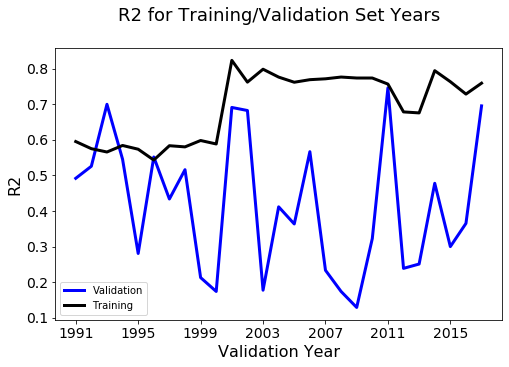

In [30]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.lineplot(x = df_validationR2.index, y = 'R2', data = df_validationR2, color = 'blue', linewidth = 3, label = 'Validation')
ax = sns.lineplot(x = df_trainR2.index, y = 'R2', data = df_trainR2, color = 'black', linewidth = 3, label = 'Training')

#Format ticks
ax.set_xticks(np.arange(1991, 2017, 4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#
plt.legend(loc = 'lower left')
#Format axis labels
ax.set_title('R2 for Training/Validation Set Years\n', fontsize = 18)
ax.set_ylabel('R2', fontsize = 16)
ax.set_xlabel('Validation Year', fontsize = 16)

###Plot Alpha Each Year

Text(0.5, 0, 'Validation Year')

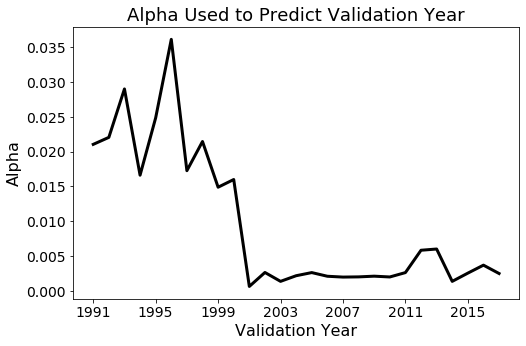

In [31]:
#Dict to collect year:R2 key:value pair
alpha = {}

#Loop through years
for year in np.arange(1991,2017+1):
  alpha[year] = model_dict[str(year)]['ALPHA']

df_alpha = pd.Series(alpha).to_frame(name = 'Alpha')
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.lineplot(x = df_alpha.index, y = 'Alpha', data = df_alpha, color = 'black', linewidth = 3)

#Format ticks
ax.set_xticks(np.arange(1991, 2017, 4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#Format axis labels
ax.set_title('Alpha Used to Predict Validation Year', fontsize = 18)
ax.set_ylabel('Alpha', fontsize = 16)
ax.set_xlabel('Validation Year', fontsize = 16)

###Plot Intercept Each Year

Text(0.5, 0, 'Validation Year')

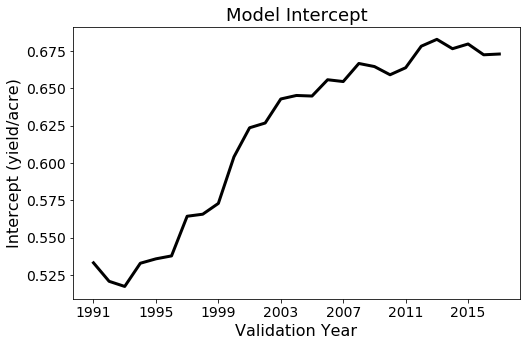

In [32]:
#Dict to collect year:R2 key:value pair
intercept = {}

#Loop through years
for year in np.arange(1991,2017+1):
  intercept[year] = model_dict[str(year)]['INTERCEPT']

df_intercept = pd.Series(intercept).to_frame(name = 'R2')
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.lineplot(x = df_intercept.index, y = 'R2', data = df_intercept, color = 'black', linewidth = 3)

#Format ticks
ax.set_xticks(np.arange(1991, 2017, 4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#Format axis labels
ax.set_title('Model Intercept', fontsize = 18)
ax.set_ylabel('Intercept (yield/acre)', fontsize = 16)
ax.set_xlabel('Validation Year', fontsize = 16)

###Feature Selcetion Analysis

In [0]:
features = {}

#Loop through years 2000 onward
for year in np.arange(2000,2017+1):
  features[year] = model_dict[str(year)]['FEATURES']

#Top positive coefs including counties
top_5 = []
for year in np.arange(2000,2017+1):
  df_year = features[year]
  df_nonzero = df_year[df_year['Coef'] != 0].sort_values(by = 'Coef', ascending = False)

  df_top = df_nonzero[['Features']].reset_index(drop = True).rename(columns = {'Features':year}).head(5)

  top_5.append(df_top)

#####Climate and year only, no counties#####

#Top positive coefs, climate and year only
counties = df_weather_yield['County'].unique()

#Store dfs for most positive features
top_5_climate = []

#Store dfs for most negative features
bottom_5_climate = []

#Store arrays of words for ALL features
top_5_climate_words = []

for year in np.arange(2000,2017+1):
  #Filtering to given year, nonzero coefs, and no counties
  df_year = features[year]
  df_nonzero = df_year[df_year['Coef'] != 0].sort_values(by = 'Coef', ascending = False)
  df_climate = df_nonzero[~df_nonzero['Features'].isin(counties)]

  #Store in word list
  top_5_climate_words.append(df_climate['Features'].values)

  #Rename df by year. Only take top 5 most positive.
  df_top = df_climate[['Features', 'Coef']].reset_index(drop = True).rename(columns = {'Features':year}).head(5)
  
  #Take 5 most negative
  df_bottom = df_climate[['Features', 'Coef']].rename(columns = {'Features':year}).tail(5).reset_index(drop = True)

  #Store df in list
  top_5_climate.append(df_top)
  bottom_5_climate.append(df_bottom)

**Flatten a list of lists into one list.**

In [0]:
flat_list = []
for sublist in top_5_climate_words:
    for item in sublist:
        flat_list.append(item)

**Use Counter package to count the number of times each word appears.**

In [0]:
from collections import Counter
word_counts = Counter(flat_list)

#Convert from dict to df
data = pd.Series(word_counts).to_frame(name = 'Frequency')
data = data.sort_values(by = 'Frequency')

**Make a bar plot to display the counts of each word.**

Text(0.5, 0, 'Feature')

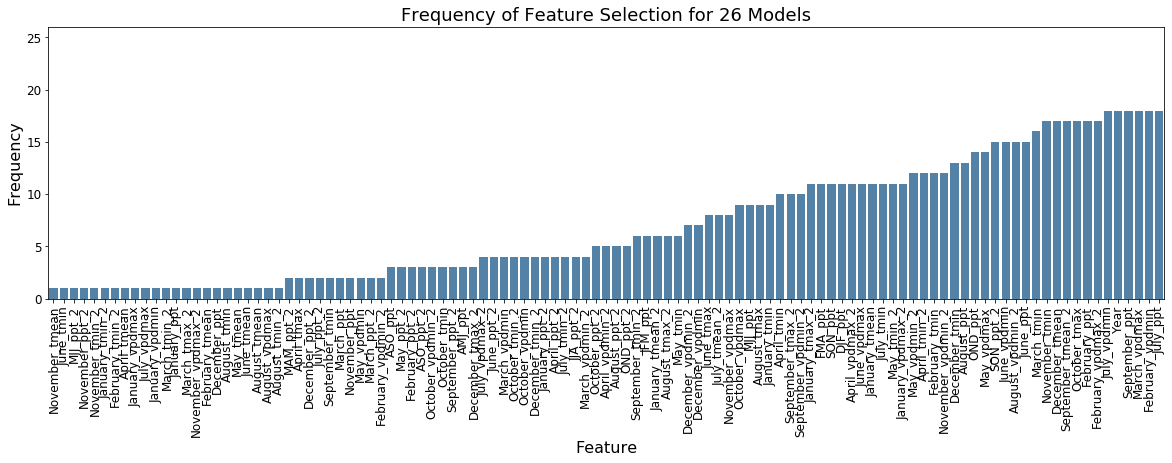

In [36]:
fig, ax = plt.subplots(figsize = (20,5))

ax = sns.barplot(x = data.index, y = 'Frequency', data = data, color = 'steelblue')

plt.xticks(rotation = 90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.set_ylim(0, 26)

ax.set_title('Frequency of Feature Selection for 26 Models', fontsize = 18)
ax.set_ylabel('Frequency', fontsize = 16)
ax.set_xlabel('Feature', fontsize = 16)

**Tabular format bc above is hard to read.**

In [37]:
data.tail(5)

Frequency
Year                    18
September_ppt           18
March_vpdmax            18
February_vpdmin         18
July_ppt                18

**Take a look at the top 5 positive predictors for each year.**

In [38]:
top_5_climate_ = pd.concat(top_5_climate, axis = 1)
top_5_climate_

2000      Coef  ...               2017      Coef
0  September_tmean_2  0.040735  ...               Year  0.136254
1          July_tmin  0.034163  ...  September_tmean_2  0.068634
2        June_vpdmin  0.026633  ...        July_vpdmin  0.059220
3               Year  0.023945  ...        August_tmax  0.030935
4        July_vpdmin  0.021175  ...       March_vpdmax  0.021949

[5 rows x 36 columns]

In [39]:
bottom_5_climate_ = pd.concat(bottom_5_climate, axis = 1)
bottom_5_climate_

2000      Coef  ...                2017      Coef
0   January_tmax_2 -0.028054  ...          March_tmin -0.030142
1    February_tmin -0.033022  ...      December_tmean -0.031792
2          FMA_ppt -0.033695  ...  September_vpdmin_2 -0.032443
3  February_vpdmin -0.041751  ...        October_tmax -0.040701
4   December_tmean -0.084939  ...       February_tmin -0.041905

[5 rows x 36 columns]

### Detrend Results

Concatenate all the observed and predicted yields together. Include the year and county of each observation.

In [0]:
data = []

for year in np.arange(1991,2017+1):

  observed = model_dict[str(year)]['OBSERVED YIELD/ACRE']
  #Add year columns
  observed['Year'] = year

  predicted = model_dict[str(year)]['PREDICTED YIELD/ACRE']

  #Join predicted and observed
  df = pd.merge(left = observed, right = predicted, how = 'inner', on = 'County')
  data.append(df)

all_yields = pd.concat(data)

Plot the observed and predicted yield overtime. Color points by county.

Text(0.5, 1.0, 'Observed Yield per Acre')

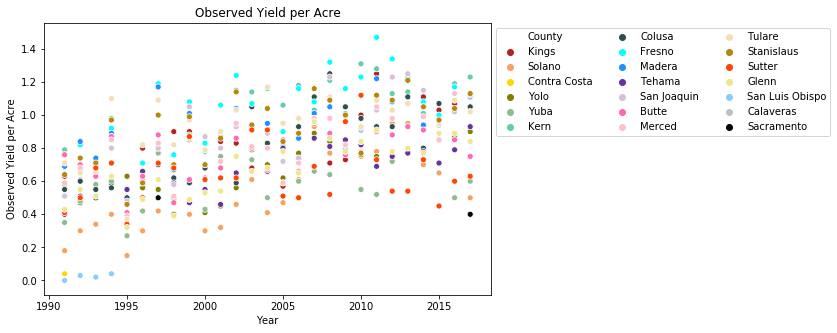

In [41]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Observed Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Observed Yield per Acre')

Text(0.5, 1.0, 'Predicted Yield per Acre')

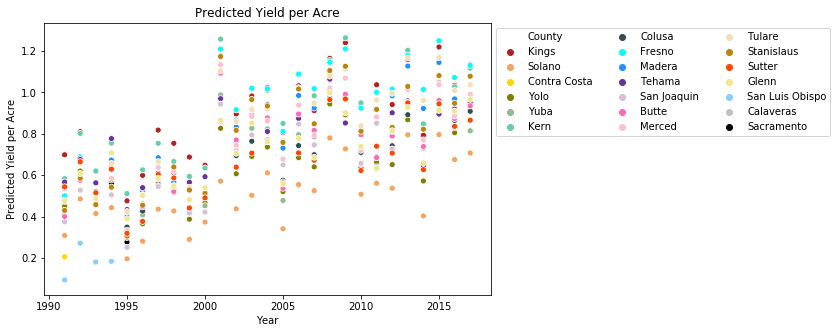

In [42]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Predicted Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Predicted Yield per Acre')

To remove the trend from the yields, we need to fit a model to the data based on the year. Then we subtract the NEW predicted value from the old one.

In [0]:
#Let's practice with the observed yield per acre first
target = all_yields['Observed Yield per Acre'].values
predictor = all_yields['Year'].values
predictor_formatted = np.reshape(predictor, (len(predictor), 1))

model = linear_model.LinearRegression()
model.fit(predictor_formatted, target)

trend = model.predict(predictor_formatted)

Text(0.5, 1.0, 'Observed Yield per Acre')

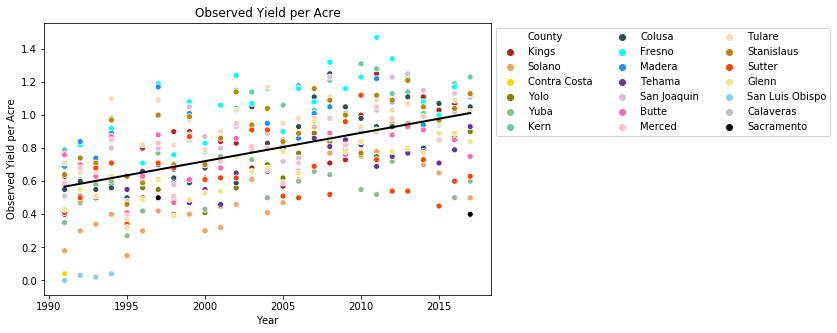

In [44]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Observed Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
plt.plot(predictor, trend, color = 'black', linewidth = 2)
ax.set_title('Observed Yield per Acre')

In [0]:
#Detrend the observed yield per acre
all_yields['Observed Year Trend'] = trend
all_yields['Detrended Observed Yield per Acre'] = all_yields['Observed Yield per Acre'] - all_yields['Observed Year Trend']

Text(0.5, 1.0, 'Observed Yield per Acre (Detrended)')

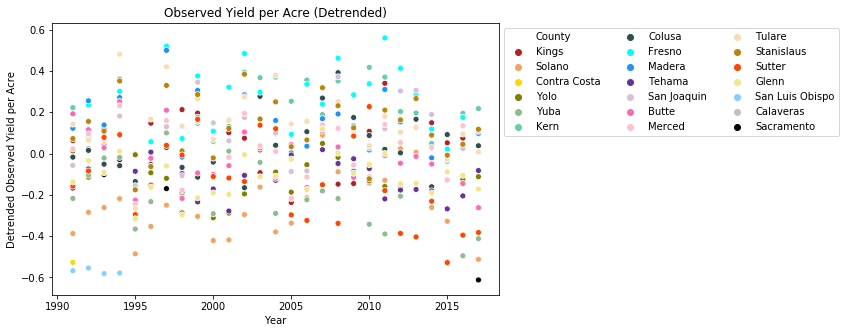

In [46]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Detrended Observed Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
ax.set_title('Observed Yield per Acre (Detrended)')

Detrend the predicted yields.

In [0]:
target = all_yields['Predicted Yield per Acre'].values
predictor = all_yields['Year'].values
predictor_formatted = np.reshape(predictor, (len(predictor), 1))

model = linear_model.LinearRegression()
model.fit(predictor_formatted, target)

trend = model.predict(predictor_formatted)

Text(0.5, 1.0, 'Predicted Yield per Acre')

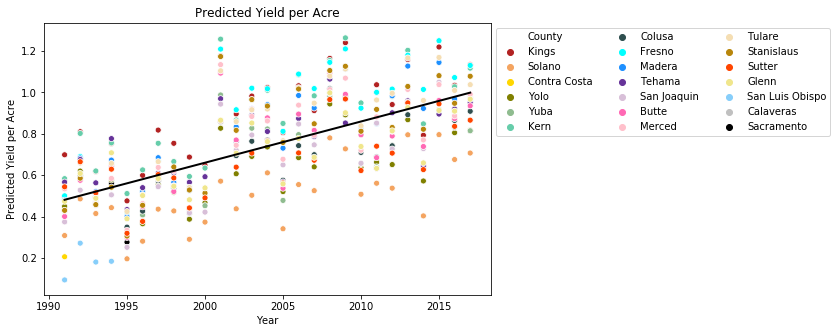

In [48]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Predicted Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
plt.plot(predictor, trend, color = 'black', linewidth = 2)
ax.set_title('Predicted Yield per Acre')

In [0]:
#Detrend the predicted yield per acre
all_yields['Predicted Year Trend'] = trend
all_yields['Detrended Predicted Yield per Acre'] = all_yields['Predicted Yield per Acre'] - all_yields['Predicted Year Trend']

Text(0.5, 1.0, 'Predicted Yield per Acre (Detrended)')

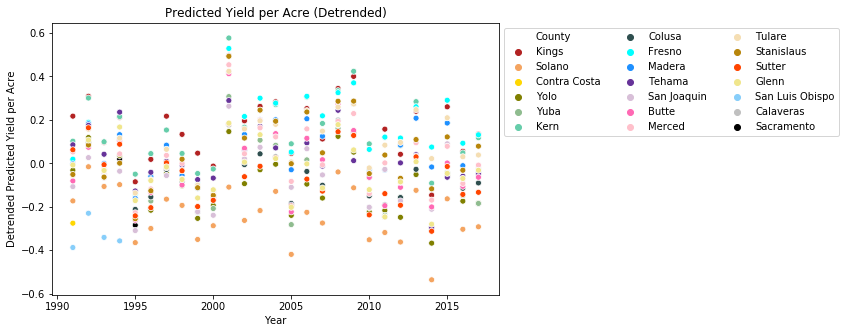

In [50]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Year', y = 'Detrended Predicted Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
ax.set_title('Predicted Yield per Acre (Detrended)')

**Now we can plot detrended observed yields vs detrended predicted yields.**

Text(0.5, 1.0, 'Observed vs Predicted (Detrended)\n R2 = 0.256')

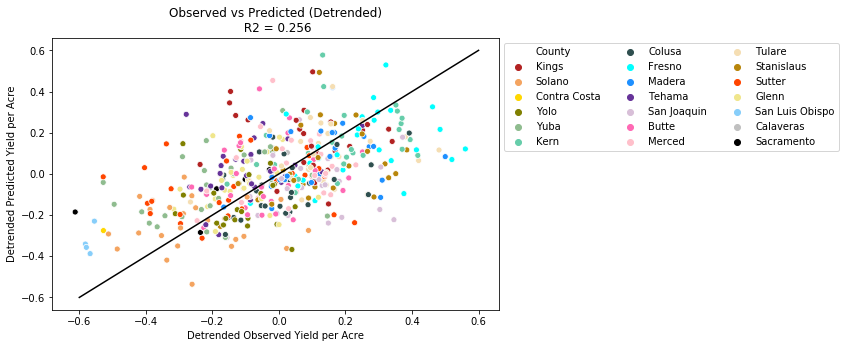

In [89]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)

#Add 1:1 line for interpretability
x = [-0.6, 0, 0.6]
y = [-0.6, 0, 0.6]
plt.plot(x,y, color = 'black')

#Calculate R2
R2 = np.corrcoef(all_yields['Detrended Observed Yield per Acre'], all_yields['Detrended Predicted Yield per Acre'])[0][1]**2

plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Observed vs Predicted (Detrended)\n R2 = ' + str(round(R2,3)))

**Add median point and 95% range.**

In [0]:
median_observed = all_yields['Detrended Observed Yield per Acre'].median()
median_predicted = all_yields['Detrended Predicted Yield per Acre'].median()

sd_observed = all_yields['Detrended Observed Yield per Acre'].std()
sd_predicted = all_yields['Detrended Predicted Yield per Acre'].std()

Text(0.5, 1.0, 'Observed vs Predicted (Detrended)\n R2 = 0.256')

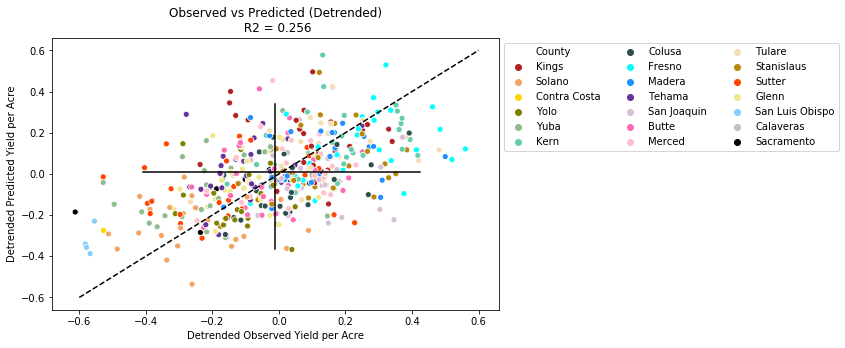

In [129]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields, hue = 'County', palette = county_colors)

#Add 1:1 line for interpretability
x = [-0.6, 0, 0.6]
y = [-0.6, 0, 0.6]
plt.plot(x,y, color = 'black', ls = '--')

#Add median point and 95% range in X and Y direction
y_predicted = [median_predicted - (2*sd_predicted), median_predicted, median_predicted + (2*sd_predicted)]
x_predicted = [median_predicted] * 3

y_observed = [median_observed] * 3
x_observed = [median_observed - (2*sd_observed), median_observed, median_observed + (2*sd_observed)]

plt.plot(x_predicted, y_predicted, color = 'black')
plt.plot(x_observed, y_observed, color = 'black')

#Calculate R2
R2 = np.corrcoef(all_yields['Detrended Observed Yield per Acre'], all_yields['Detrended Predicted Yield per Acre'])[0][1]**2

plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Observed vs Predicted (Detrended)\n R2 = ' + str(round(R2,3)))

**We can average the observed and predicted yields in each county for an alternative perspective.**

Text(0.5, 1.0, 'Avg Observed vs Avg Predicted (Detrended)\n R2 = 0.856')

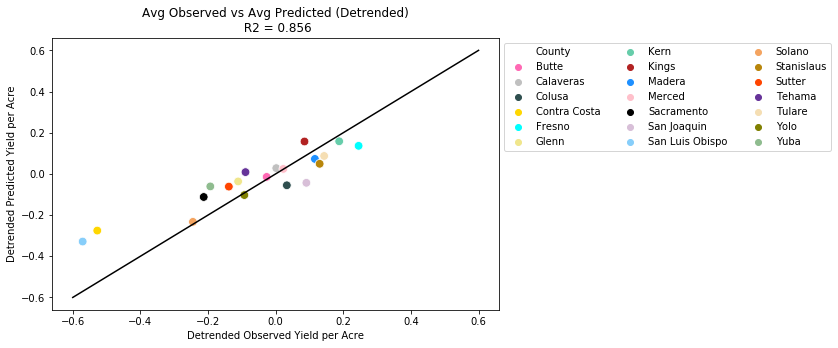

In [81]:
#Group by county
all_yields_avg_county = all_yields[['County', 'Detrended Observed Yield per Acre', 'Detrended Predicted Yield per Acre']]
all_yields_avg_county = all_yields_avg_county.groupby('County').mean().reset_index()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields_avg_county, hue = 'County', palette = county_colors, s = 75)

#Add 1:1 line for interpretability
x = [-0.6, 0, 0.6]
y = [-0.6, 0, 0.6]
plt.plot(x,y, color = 'black')

#Calculate R2
R2 = np.corrcoef(all_yields_avg_county['Detrended Observed Yield per Acre'], all_yields_avg_county['Detrended Predicted Yield per Acre'])[0][1]**2

plt.legend(ncol = 3, bbox_to_anchor = (1,1))
ax.set_title('Avg Observed vs Avg Predicted (Detrended)\n R2 = ' + str(round(R2,3)))

In [62]:
#Tabular format because colors are hard to disintguish
all_yields_avg_county.sort_values(by = 'Detrended Observed Yield per Acre')

County  ...  Detrended Predicted Yield per Acre
12  San Luis Obispo  ...                           -0.328490
3      Contra Costa  ...                           -0.275209
13           Solano  ...                           -0.232898
10       Sacramento  ...                           -0.112142
19             Yuba  ...                           -0.060786
15           Sutter  ...                           -0.061692
5             Glenn  ...                           -0.036616
18             Yolo  ...                           -0.102791
16           Tehama  ...                            0.008692
0             Butte  ...                           -0.014562
1         Calaveras  ...                            0.028017
9            Merced  ...                            0.024235
2            Colusa  ...                           -0.055298
7             Kings  ...                            0.157398
11      San Joaquin  ...                           -0.043298
8            Madera  ...                            0.072739
14       Stanislaus  ...                            0.049020
17           Tulare  ...                            0.087093
6              Kern  ...                            0.158329
4            Fresno  ...                            0.136290

[20 rows x 3 columns]

**Interpretation of above: It seems like the model actually does fairly well for all the counties except San Luis Obispo and Contra Costa.**

**We can do the same analysis as above but this time color by years instead of counties.**

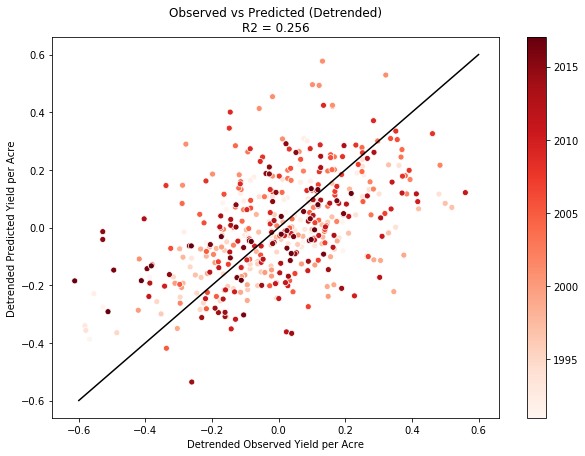

In [92]:
#Create colorbar
norm = plt.Normalize(all_yields['Year'].min(), all_yields['Year'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

#Plot
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields, hue = 'Year', palette = 'Reds')

#R2
R2 = np.corrcoef(all_yields['Detrended Observed Yield per Acre'], all_yields['Detrended Predicted Yield per Acre'])[0][1]**2

#Add 1:1 line for interpretability
x = [-0.6, 0, 0.6]
y = [-0.6, 0, 0.6]
plt.plot(x,y, color = 'black')
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
ax.set_title('Observed vs Predicted (Detrended)\nR2 = ' + str(round(R2,3)))

#Color bar
ax.get_legend().remove()
ax.figure.colorbar(sm)

**Add a median point and 95% range cross**

In [97]:
median_observed = all_yields['Detrended Observed Yield per Acre'].median()
median_predicted = all_yields['Detrended Predicted Yield per Acre'].median()

sd_observed = all_yields['Detrended Observed Yield per Acre'].std()
sd_predicted = all_yields['Detrended Predicted Yield per Acre'].std()

0.007333139459383797

Text(0.5, 1.0, 'Observed vs Predicted (Detrended)\nR2 = 0.256')

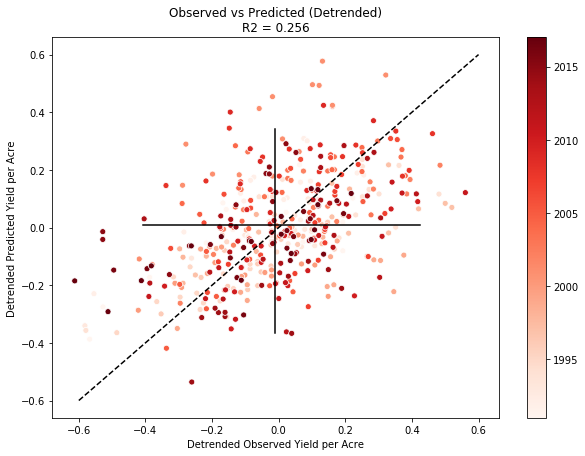

In [126]:
#Create colorbar
norm = plt.Normalize(all_yields['Year'].min(), all_yields['Year'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

#Main Scatter
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields, hue = 'Year', palette = 'Reds')

#Add 1:1 line for interpretability
x = [-0.6, 0, 0.6]
y = [-0.6, 0, 0.6]
plt.plot(x,y, color = 'black', ls = '--')

#Add median point and 95% range in X and Y direction
y_predicted = [median_predicted - (2*sd_predicted), median_predicted, median_predicted + (2*sd_predicted)]
x_predicted = [median_predicted] * 3

y_observed = [median_observed] * 3
x_observed = [median_observed - (2*sd_observed), median_observed, median_observed + (2*sd_observed)]

plt.plot(x_predicted, y_predicted, color = 'black')
plt.plot(x_observed, y_observed, color = 'black')

#Calculate R2 for scatterplot
R2 = np.corrcoef(all_yields['Detrended Observed Yield per Acre'], all_yields['Detrended Predicted Yield per Acre'])[0][1]**2

#Color bar
ax.get_legend().remove()
ax.figure.colorbar(sm)

#Title
ax.set_title('Observed vs Predicted (Detrended)\nR2 = ' + str(round(R2,3)))

**Average over years for alternative perspective.**

In [0]:
#Group by year
all_yields_avg_year = all_yields[['Year', 'Detrended Observed Yield per Acre', 'Detrended Predicted Yield per Acre']]
all_yields_avg_year = all_yields_avg_year.groupby('Year').mean().reset_index()

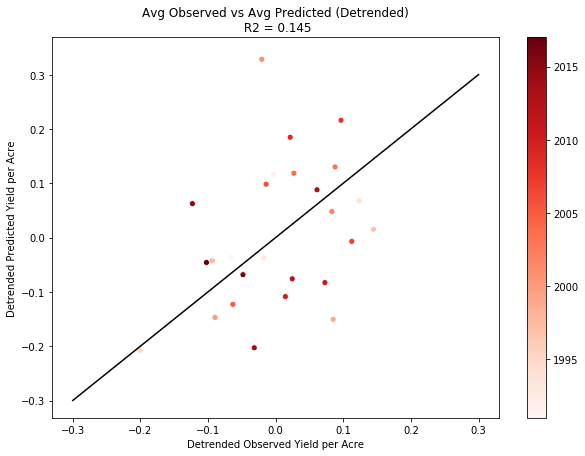

In [88]:
#Create colorbar
norm = plt.Normalize(all_yields['Year'].min(), all_yields['Year'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

#Plot
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.scatterplot(x = 'Detrended Observed Yield per Acre', y = 'Detrended Predicted Yield per Acre', data = all_yields_avg_year, hue = 'Year', palette = 'Reds')

#R2 
R2 = np.corrcoef(all_yields_avg_year['Detrended Observed Yield per Acre'], all_yields_avg_year['Detrended Predicted Yield per Acre'])[0][1]**2

#Add 1:1 line for interpretability
x = [-0.3, 0, 0.3]
y = [-0.3, 0, 0.3]
plt.plot(x,y, color = 'black')
plt.legend(ncol = 3, bbox_to_anchor = (1,1))
ax.set_title('Avg Observed vs Avg Predicted (Detrended)\n R2 = ' + str(round(R2,3)))

#Color bar
ax.get_legend().remove()
ax.figure.colorbar(sm)

### Residual Analysis

Text(0.5, 1.0, 'Residuals\n Trended Observed Yield - Trended Predicted Yield')

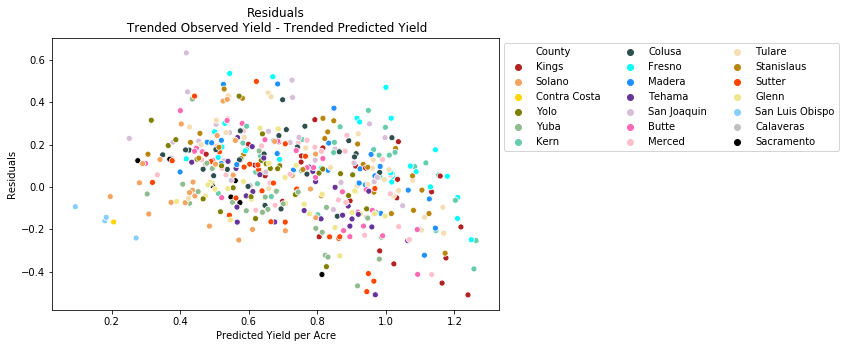

In [0]:
all_yields['Residuals'] = all_yields['Observed Yield per Acre'] - all_yields['Predicted Yield per Acre']
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Predicted Yield per Acre', y = 'Residuals', data = all_yields, hue = 'County', palette = county_colors)
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Residuals\n Trended Observed Yield - Trended Predicted Yield')

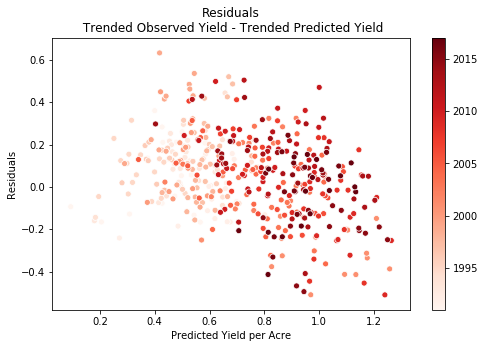

In [0]:
#Color bar
norm = plt.Normalize(all_yields['Year'].min(), all_yields['Year'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

all_yields['Residuals'] = all_yields['Observed Yield per Acre'] - all_yields['Predicted Yield per Acre']
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'Predicted Yield per Acre', y = 'Residuals', data = all_yields, hue = 'Year', palette = 'Reds')
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

ax.set_title('Residuals\n Trended Observed Yield - Trended Predicted Yield')

#Color bar

#Color bar
ax.get_legend().remove()
ax.figure.colorbar(sm)

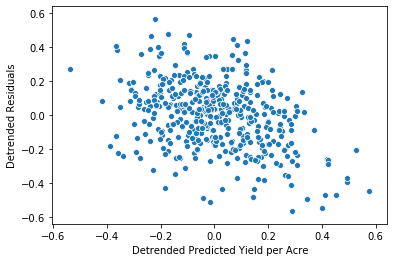

In [0]:
all_yields['Detrended Residuals'] = all_yields['Detrended Observed Yield per Acre'] - all_yields['Detrended Predicted Yield per Acre']
sns.scatterplot(x = 'Detrended Predicted Yield per Acre', y = 'Detrended Residuals', data = all_yields)

Text(0, 0.5, 'Frequency')

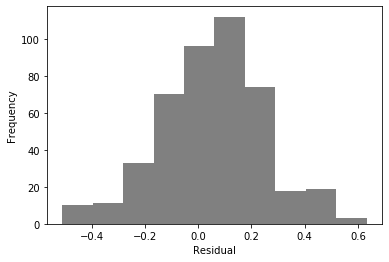

In [0]:
plt.hist(all_yields['Residuals'], color = 'grey')
plt.xlabel('Residual')
plt.ylabel('Frequency')


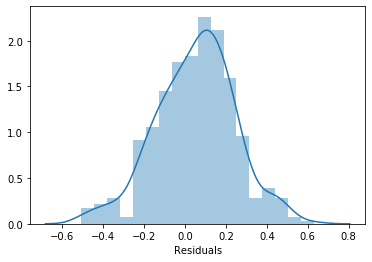

In [0]:
sns.distplot(all_yields['Residuals'], kde= 'False')